# Table of Contents

### [Read Json From HDFS](#1.-Read-Json-From-HDFS)
### [Sensors DataFrame](#2.-Sensors-DataFrame)
### [Fails DataFrame](#3.-Fails-DataFrame)
### [Merge DataFrame Sensors and Fails](#4.-Merge-DataFrame-Sensors-and-Fails)
### [Parse time by minute](#5.-Parse-time-by-minute)
### [Parse time by hour](#6.-Parse-time-by-hour)
### [Create Hive Table](#7.-Create-Hive-Table)
### [H2O](#8.-H2O)
### [Auto-Arima](#9.-Auto-Arima)
### [Prophet](#10.-Prophet)

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import Row
from pyspark.sql.functions import explode, min, max, col, round, hour, minute, count, dayofmonth, month, substring, avg
from pyspark.sql.types import IntegerType
from pyspark.sql.types import TimestampType
import pandas as pd
import numpy as np
import seaborn as sns

warehouse_location = 'hdfs://namenode:8020/warehouse'
spark = SparkSession \
    .builder \
    .appName("Python Spark SQL Hive integration example") \
    .config("spark.sql.warehouse.dir", warehouse_location) \
    .config("hive.metastore.uris", "thrift://hive-metastore:9083") \
    .enableHiveSupport() \
    .getOrCreate()

21/12/06 16:47:11 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


# 1. Read Json From HDFS
         hdfs://namenode:8020//raw/fails
         hdfs://namenode:8020//raw/sensors

In [2]:
df_falhas = spark.read.json('hdfs://namenode:8020//raw/fails/0ecf7960-d06a-42c6-b557-24feec7e3d5b', multiLine = True)

df_sensores = spark.read.json('hdfs://namenode:8020//raw/sensors/2fa329b8-8c5e-4923-9686-af7b0cbf16f2', multiLine = True)


In [3]:
_df_s = df_sensores.withColumn("results", explode("results")) \
                    .withColumn("sensor_created_at", col("results")["sensor_created_at"].cast("timestamp")) \
                    .withColumn("sensor_event_type", col("results")["sensor_event_type"].cast("string")) \
                    .withColumn("sensor_id_cycle", col("results")["sensor_id_cycle"].cast("integer")) \
                    .withColumn("sensor_ip", col("results")["sensor_ip"].cast("string")) \
                    .withColumn("sensor_unique_id", col("results")["sensor_unique_id"].cast("string")) \
                    .withColumn("sensor_value_humidity", col("results")["sensor_value_humidity"].cast("integer")) \
                    .withColumn("sensor_value_temperature_motor1", col("results")["sensor_value_temperature_motor1"].cast("integer")) \
                    .withColumn("sensor_value_temperature_motor2", col("results")["sensor_value_temperature_motor2"].cast("integer")) \
                    .withColumn("sensor_value_temperature_motor3", col("results")["sensor_value_temperature_motor3"].cast("integer")) \
                    .withColumn("sensor_value_vibrationhz_x", col("results")["sensor_value_vibrationhz_x"].cast("integer")) \
                    .withColumn("sensor_value_vibrationhz_y", col("results")["sensor_value_vibrationhz_y"].cast("integer")) \
                    .withColumn("sensor_value_vibrationhz_z", col("results")["sensor_value_vibrationhz_z"].cast("integer")) \
                    .withColumn("value_noise_dba_motor1", col("results")["value_noise_dba_motor1"].cast("integer")) \
                    .withColumn("value_noise_dba_motor2", col("results")["value_noise_dba_motor2"].cast("integer")) \
                    .withColumn("value_noise_dba_motor3", col("results")["value_noise_dba_motor3"].cast("integer")) \
                    .drop("results") \
                    .orderBy("sensor_created_at")
_sen = _df_s.toPandas()

In [4]:
_df_f = df_falhas.withColumn("results", explode("results")) \
                .withColumn("falha_created_at", col("results")["falha_created_at"].cast("timestamp")) \
                .withColumn("falha_id_falha", col("results")["falha_id_falha"].cast("string")) \
                .withColumn("falha_ip", col("results")["falha_ip"].cast("string")) \
                .withColumn("falha_hostname", col("results")["falha_hostname"].cast("string")) \
                .withColumn("falha_event_type", col("results")["falha_event_type"].cast("string")) \
                .withColumn("falha_tipo_falha", col("results")["falha_tipo_falha"].cast("string")) \
                .withColumn("falha_error_code", col("results")["falha_error_code"].cast("string")) \
                .withColumn("falha_error_description", col("results")["falha_error_description"].cast("string")) \
                .drop("results") \
                .orderBy("falha_created_at")
_fai = _df_f.toPandas()

## 2. Sensors DataFrame

In [5]:
_sen

,sensor_created_at,sensor_event_type,sensor_id_cycle,sensor_ip,sensor_unique_id,sensor_value_humidity,sensor_value_temperature_motor1,sensor_value_temperature_motor2,sensor_value_temperature_motor3,sensor_value_vibrationhz_x,sensor_value_vibrationhz_y,sensor_value_vibrationhz_z,value_noise_dba_motor1,value_noise_dba_motor2,value_noise_dba_motor3
0,2021-11-25 12:25:35.015,sensor,4,172.18.0.2,e269fcc6-7737-410a-9bad-938f4d926247,23,19,28,8,11,14,20,23,47,23
1,2021-11-25 12:25:40.016,sensor,1,172.18.0.2,e461209a-82fe-4ce9-9fb2-d7cebd3b2fa5,22,26,21,27,19,16,20,39,58,46
2,2021-11-25 12:25:45.017,sensor,1,172.18.0.2,bf19c9e6-638a-47b0-a499-33878176943b,81,7,30,29,10,16,15,34,63,39
3,2021-11-25 12:25:50.019,sensor,4,172.18.0.2,26e31171-15f2-4005-b654-54a2e12dc4dc,41,18,23,11,18,11,21,26,20,44
4,2021-11-25 12:25:55.020,sensor,4,172.18.0.2,027c718e-a87e-453a-b0fb-e884f280db4a,42,11,32,17,12,15,14,36,28,40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173664,2021-12-05 13:41:56.458,sensor,4,172.18.0.2,a941a58c-ab72-4b0a-be5c-9d545b4012a3,20,21,21,23,17,15,10,56,46,64
173665,2021-12-05 13:42:01.459,sensor,5,172.18.0.2,0512f6c4-b48a-4b88-895b-fee697b07c0e,79,6,29,14,13,20,14,58,51,17
173666,2021-12-05 13:42:06.459,sensor,1,172.18.0.2,3505c013-f92c-49ab-abee-d9e17c3c250f,42,15,26,30,21,19,15,33,59,30
173667,2021-12-05 13:42:11.461,sensor,3,172.18.0.2,ef36431a-3554-4ac3-9241-febd621fc8fb,75,8,26,6,12,19,20,18,24,16


## 3. Fails DataFrame

In [6]:
_fai

,falha_created_at,falha_id_falha,falha_ip,falha_hostname,falha_event_type,falha_tipo_falha,falha_error_code,falha_error_description
0,2021-11-25 16:44:19.978,0c57eba9-1fb8-461a-af31-d0b33c77ee99,172.18.0.2,32e102a5111a,fail,falha_1,erro_500,Pequena falha
1,2021-11-25 16:44:25.021,65bd9df3-2310-4299-bba5-9185da1075a6,172.18.0.2,32e102a5111a,fail,falha_2,erro_500,Falha Geral
2,2021-11-25 16:44:34.911,1c691588-3c43-4e28-84fc-f2edaf98e85f,172.18.0.2,32e102a5111a,fail,falha_3,erro_500,Falha Crítica
3,2021-11-25 17:44:19.980,422e18aa-1b4a-4186-aabb-a022ac854caf,172.18.0.2,32e102a5111a,fail,falha_1,erro_500,Pequena falha
4,2021-11-25 18:44:19.980,8bf65258-ec7a-4b65-b552-a9cc396e17c3,172.18.0.2,32e102a5111a,fail,falha_1,erro_500,Pequena falha
...,...,...,...,...,...,...,...,...
389,2021-12-05 10:04:34.949,804c08f7-4eb4-42e1-b217-b88c5a0d32b7,172.18.0.2,32e102a5111a,fail,falha_3,erro_500,Falha Crítica
390,2021-12-05 10:44:20.180,a3ceeb4d-7154-4329-9d77-f0593f6057e9,172.18.0.2,32e102a5111a,fail,falha_1,erro_500,Pequena falha
391,2021-12-05 11:44:20.181,2e153b65-caa1-477f-acb6-d0702affb821,172.18.0.2,32e102a5111a,fail,falha_1,erro_500,Pequena falha
392,2021-12-05 12:09:25.117,65da7cec-41ab-4732-8dc9-28f9684821a6,172.18.0.2,32e102a5111a,fail,falha_2,erro_500,Falha Geral


## Rename Columns

In [7]:
_fails = _fai[["falha_created_at", "falha_tipo_falha", "falha_error_description"]]
_fails.rename(columns = {'falha_created_at':'sensor_created_at'}, inplace = True)

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4449: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


## 4. Merge DataFrame Sensors and Fails

In [8]:
import pandas as pd
test = pd.merge_asof(_sen, _fails, on="sensor_created_at", tolerance=pd.Timedelta("4s"))

In [9]:
test["falha_error_description"].value_counts()

Pequena falha    183
Falha Geral       91
Falha Crítica     34
Name: falha_error_description, dtype: int64

   ## Replace Nulls by "sem_falha"

In [10]:
df_test = test.copy()
df_test = test.fillna('sem_falha')

## Merged Dataframe

In [11]:
df_test

,sensor_created_at,sensor_event_type,sensor_id_cycle,sensor_ip,sensor_unique_id,sensor_value_humidity,sensor_value_temperature_motor1,sensor_value_temperature_motor2,sensor_value_temperature_motor3,sensor_value_vibrationhz_x,sensor_value_vibrationhz_y,sensor_value_vibrationhz_z,value_noise_dba_motor1,value_noise_dba_motor2,value_noise_dba_motor3,falha_tipo_falha,falha_error_description
0,2021-11-25 12:25:35.015,sensor,4,172.18.0.2,e269fcc6-7737-410a-9bad-938f4d926247,23,19,28,8,11,14,20,23,47,23,sem_falha,sem_falha
1,2021-11-25 12:25:40.016,sensor,1,172.18.0.2,e461209a-82fe-4ce9-9fb2-d7cebd3b2fa5,22,26,21,27,19,16,20,39,58,46,sem_falha,sem_falha
2,2021-11-25 12:25:45.017,sensor,1,172.18.0.2,bf19c9e6-638a-47b0-a499-33878176943b,81,7,30,29,10,16,15,34,63,39,sem_falha,sem_falha
3,2021-11-25 12:25:50.019,sensor,4,172.18.0.2,26e31171-15f2-4005-b654-54a2e12dc4dc,41,18,23,11,18,11,21,26,20,44,sem_falha,sem_falha
4,2021-11-25 12:25:55.020,sensor,4,172.18.0.2,027c718e-a87e-453a-b0fb-e884f280db4a,42,11,32,17,12,15,14,36,28,40,sem_falha,sem_falha
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173664,2021-12-05 13:41:56.458,sensor,4,172.18.0.2,a941a58c-ab72-4b0a-be5c-9d545b4012a3,20,21,21,23,17,15,10,56,46,64,sem_falha,sem_falha
173665,2021-12-05 13:42:01.459,sensor,5,172.18.0.2,0512f6c4-b48a-4b88-895b-fee697b07c0e,79,6,29,14,13,20,14,58,51,17,sem_falha,sem_falha
173666,2021-12-05 13:42:06.459,sensor,1,172.18.0.2,3505c013-f92c-49ab-abee-d9e17c3c250f,42,15,26,30,21,19,15,33,59,30,sem_falha,sem_falha
173667,2021-12-05 13:42:11.461,sensor,3,172.18.0.2,ef36431a-3554-4ac3-9241-febd621fc8fb,75,8,26,6,12,19,20,18,24,16,sem_falha,sem_falha


## 5. Parse time by minute

In [12]:
dfs2 = _df_s.withColumn("sensor_dayOfMonth", dayofmonth("sensor_created_at")) \
             .withColumn("sensor_month", month("sensor_created_at")) \
             .withColumn("sensor_hour", substring("sensor_created_at", 11, 13)) \
             .withColumn("sensor_date", substring("sensor_created_at", 0, 10)) \
             .withColumn("sensor_datehhmm", substring("sensor_created_at", 0, 15).cast(TimestampType())) \
              .orderBy("sensor_datehhmm")

## Dataframe with sensor_datehhmm by minute

In [13]:
dfs2.toPandas()

,sensor_created_at,sensor_event_type,sensor_id_cycle,sensor_ip,sensor_unique_id,sensor_value_humidity,sensor_value_temperature_motor1,sensor_value_temperature_motor2,sensor_value_temperature_motor3,sensor_value_vibrationhz_x,sensor_value_vibrationhz_y,sensor_value_vibrationhz_z,value_noise_dba_motor1,value_noise_dba_motor2,value_noise_dba_motor3,sensor_dayOfMonth,sensor_month,sensor_hour,sensor_date,sensor_datehhmm
0,2021-11-25 12:28:40.075,sensor,4,172.18.0.2,69c0e64a-e345-4b83-b206-a5476844c2bf,45,27,8,9,13,17,16,55,46,29,25,11,12:28:40.075,2021-11-25,2021-11-25 12:02:00
1,2021-11-25 12:26:05.022,sensor,3,172.18.0.2,b6099a82-79bb-4f63-984d-90ee76e14479,69,14,16,7,12,12,15,47,63,38,25,11,12:26:05.022,2021-11-25,2021-11-25 12:02:00
2,2021-11-25 12:27:55.063,sensor,3,172.18.0.2,e7b47472-d226-4186-a304-e9627602c595,84,21,29,19,17,18,13,41,36,45,25,11,12:27:55.063,2021-11-25,2021-11-25 12:02:00
3,2021-11-25 12:28:45.076,sensor,1,172.18.0.2,01eba910-4907-485e-9599-d48000dede20,33,14,20,24,19,17,21,61,42,48,25,11,12:28:45.076,2021-11-25,2021-11-25 12:02:00
4,2021-11-25 12:26:45.034,sensor,3,172.18.0.2,07c8807c-e747-4caf-9375-d2bc6bc9d403,77,7,13,21,16,10,14,46,19,33,25,11,12:26:45.034,2021-11-25,2021-11-25 12:02:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173664,2021-12-05 13:40:56.443,sensor,2,172.18.0.2,bbcbb547-2092-465d-9077-255fd84721c5,78,20,7,16,16,19,15,30,60,29,5,12,13:40:56.443,2021-12-05,2021-12-05 13:04:00
173665,2021-12-05 13:40:11.435,sensor,4,172.18.0.2,fd21b240-ed93-4758-b0f8-81f9e50e518f,28,24,7,15,13,18,10,40,19,17,5,12,13:40:11.435,2021-12-05,2021-12-05 13:04:00
173666,2021-12-05 13:41:31.449,sensor,2,172.18.0.2,1083059e-728a-43ac-a9fc-bc0090820a99,45,11,9,34,20,20,12,45,40,37,5,12,13:41:31.449,2021-12-05,2021-12-05 13:04:00
173667,2021-12-05 13:42:01.459,sensor,5,172.18.0.2,0512f6c4-b48a-4b88-895b-fee697b07c0e,79,6,29,14,13,20,14,58,51,17,5,12,13:42:01.459,2021-12-05,2021-12-05 13:04:00


In [14]:
dfs2

DataFrame[sensor_created_at: timestamp, sensor_event_type: string, sensor_id_cycle: int, sensor_ip: string, sensor_unique_id: string, sensor_value_humidity: int, sensor_value_temperature_motor1: int, sensor_value_temperature_motor2: int, sensor_value_temperature_motor3: int, sensor_value_vibrationhz_x: int, sensor_value_vibrationhz_y: int, sensor_value_vibrationhz_z: int, value_noise_dba_motor1: int, value_noise_dba_motor2: int, value_noise_dba_motor3: int, sensor_dayOfMonth: int, sensor_month: int, sensor_hour: string, sensor_date: string, sensor_datehhmm: timestamp]

In [15]:
dfs2.describe()

DataFrame[summary: string, sensor_event_type: string, sensor_id_cycle: string, sensor_ip: string, sensor_unique_id: string, sensor_value_humidity: string, sensor_value_temperature_motor1: string, sensor_value_temperature_motor2: string, sensor_value_temperature_motor3: string, sensor_value_vibrationhz_x: string, sensor_value_vibrationhz_y: string, sensor_value_vibrationhz_z: string, value_noise_dba_motor1: string, value_noise_dba_motor2: string, value_noise_dba_motor3: string, sensor_dayOfMonth: string, sensor_month: string, sensor_hour: string, sensor_date: string]

In [16]:
dfs2.dtypes

[('sensor_created_at', 'timestamp'),
 ('sensor_event_type', 'string'),
 ('sensor_id_cycle', 'int'),
 ('sensor_ip', 'string'),
 ('sensor_unique_id', 'string'),
 ('sensor_value_humidity', 'int'),
 ('sensor_value_temperature_motor1', 'int'),
 ('sensor_value_temperature_motor2', 'int'),
 ('sensor_value_temperature_motor3', 'int'),
 ('sensor_value_vibrationhz_x', 'int'),
 ('sensor_value_vibrationhz_y', 'int'),
 ('sensor_value_vibrationhz_z', 'int'),
 ('value_noise_dba_motor1', 'int'),
 ('value_noise_dba_motor2', 'int'),
 ('value_noise_dba_motor3', 'int'),
 ('sensor_dayOfMonth', 'int'),
 ('sensor_month', 'int'),
 ('sensor_hour', 'string'),
 ('sensor_date', 'string'),
 ('sensor_datehhmm', 'timestamp')]

## Create Agg DataFrame with Avg, Max, Min

In [17]:
colName = "sensor_value_humidity"

df3 = dfs2.groupBy("sensor_datehhmm", "sensor_ip") \
     .agg( \
     min("sensor_value_humidity").alias('min_humidity'), \
     max("sensor_value_humidity").alias('max_humidity'), \
     round(avg("sensor_value_humidity"), 2).alias('avg_humidity'), \
     min("sensor_value_temperature_motor1").alias('min_temp_motor1'), \
     max("sensor_value_temperature_motor1").alias('max_temp_motor1'), \
     round(avg("sensor_value_temperature_motor1"), 2).alias('avg_temp_motor1'), \
     min("sensor_value_temperature_motor2").alias('min_temp_motor2'), \
     max("sensor_value_temperature_motor2").alias('max_temp_motor2'), \
     round(avg("sensor_value_temperature_motor2"), 2).alias('avg_temp_motor2'), \
     min("sensor_value_temperature_motor3").alias('min_temp_motor3'), \
     max("sensor_value_temperature_motor3").alias('max_temp_motor3'), \
     round(avg("sensor_value_temperature_motor3"), 2).alias('avg_temp_motor3'), \
     min("sensor_value_vibrationhz_x").alias('min_vibrationhz_x'), \
     max("sensor_value_vibrationhz_x").alias('max_vibrationhz_x'), \
     round(avg("sensor_value_vibrationhz_x"), 2).alias('avg_vibrationhz_x'), \
     min("sensor_value_vibrationhz_y").alias('min_vibrationhz_y'), \
     max("sensor_value_vibrationhz_y").alias('max_vibrationhz_y'), \
     round(avg("sensor_value_vibrationhz_y"), 2).alias('avg_vibrationhz_y'), \
     min("sensor_value_vibrationhz_z").alias('min_vibrationhz_z'), \
     max("sensor_value_vibrationhz_z").alias('max_vibrationhz_z'), \
     round(avg("sensor_value_vibrationhz_z"), 2).alias('avg_vibrationhz_z'), \
     min("value_noise_dba_motor1").alias('min_noise_dba_motor1'), \
     max("value_noise_dba_motor1").alias('max_noise_dba_motor1'), \
     round(avg("value_noise_dba_motor1"), 2).alias('avg_noise_dba_motor1'), \
     min("value_noise_dba_motor2").alias('min_noise_dba_motor2'), \
     max("value_noise_dba_motor2").alias('max_noise_dba_motor2'), \
     round(avg("value_noise_dba_motor2"), 2).alias('avg_noise_dba_motor2'), \
     min("value_noise_dba_motor3").alias('min_noise_dba_motor3'), \
     max("value_noise_dba_motor3").alias('max_noise_dba_motor3'), \
     round(avg("value_noise_dba_motor3"), 2).alias('avg_noise_dba_motor3'), \
     count(colName).alias("temp_count_hour")) \
     .withColumn('temp_count_hour', col('temp_count_hour').cast('int'))  \
     .orderBy("sensor_datehhmm")               


In [18]:
df3.toPandas()

21/12/06 16:48:59 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


,sensor_datehhmm,sensor_ip,min_humidity,max_humidity,avg_humidity,min_temp_motor1,max_temp_motor1,avg_temp_motor1,min_temp_motor2,max_temp_motor2,...,min_noise_dba_motor1,max_noise_dba_motor1,avg_noise_dba_motor1,min_noise_dba_motor2,max_noise_dba_motor2,avg_noise_dba_motor2,min_noise_dba_motor3,max_noise_dba_motor3,avg_noise_dba_motor3,temp_count_hour
0,2021-11-25 12:02:00,172.18.0.2,15,84,48.55,5,29,17.45,6,32,...,16,64,39.77,15,64,41.60,16,64,41.66,53
1,2021-11-25 12:03:00,172.18.0.2,15,84,54.59,5,29,16.86,5,32,...,15,63,41.30,15,64,38.48,15,64,41.52,120
2,2021-11-25 12:04:00,172.18.0.2,15,84,48.47,5,29,17.01,5,32,...,15,64,41.04,15,64,40.63,15,64,38.71,120
3,2021-11-25 12:05:00,172.18.0.2,17,84,51.70,5,29,15.83,5,32,...,15,63,39.15,15,63,37.34,15,63,38.63,120
4,2021-11-25 13:00:00,172.18.0.2,16,84,48.26,5,29,18.85,5,32,...,15,64,39.46,15,64,37.87,15,64,38.79,120
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1444,2021-12-05 13:00:00,172.18.0.2,15,84,50.21,5,29,16.89,5,32,...,15,64,37.80,15,64,41.17,15,64,38.02,120
1445,2021-12-05 13:01:00,172.18.0.2,15,84,50.36,5,29,16.93,5,32,...,15,64,38.93,15,64,40.42,15,64,41.54,120
1446,2021-12-05 13:02:00,172.18.0.2,16,83,50.22,5,29,17.24,5,32,...,15,63,37.47,15,64,40.20,15,64,37.69,120
1447,2021-12-05 13:03:00,172.18.0.2,15,84,49.62,5,29,17.92,5,32,...,15,64,40.67,15,64,38.78,16,64,39.11,120


In [19]:
df3.printSchema()

root
 |-- sensor_datehhmm: timestamp (nullable = true)
 |-- sensor_ip: string (nullable = true)
 |-- min_humidity: integer (nullable = true)
 |-- max_humidity: integer (nullable = true)
 |-- avg_humidity: double (nullable = true)
 |-- min_temp_motor1: integer (nullable = true)
 |-- max_temp_motor1: integer (nullable = true)
 |-- avg_temp_motor1: double (nullable = true)
 |-- min_temp_motor2: integer (nullable = true)
 |-- max_temp_motor2: integer (nullable = true)
 |-- avg_temp_motor2: double (nullable = true)
 |-- min_temp_motor3: integer (nullable = true)
 |-- max_temp_motor3: integer (nullable = true)
 |-- avg_temp_motor3: double (nullable = true)
 |-- min_vibrationhz_x: integer (nullable = true)
 |-- max_vibrationhz_x: integer (nullable = true)
 |-- avg_vibrationhz_x: double (nullable = true)
 |-- min_vibrationhz_y: integer (nullable = true)
 |-- max_vibrationhz_y: integer (nullable = true)
 |-- avg_vibrationhz_y: double (nullable = true)
 |-- min_vibrationhz_z: integer (nullable =

# 6. Parse time by hour

In [20]:
dfs4= _df_s.withColumn("sensor_dayOfMonth", dayofmonth("sensor_created_at")) \
             .withColumn("sensor_month", month("sensor_created_at")) \
             .withColumn("sensor_hour", substring("sensor_created_at", 11, 13)) \
             .withColumn("sensor_date", substring("sensor_created_at", 0, 10)) \
             .withColumn("sensor_datehhmm", substring("sensor_created_at", 0, 13).cast(TimestampType())) \
              .orderBy("sensor_datehhmm")

## Create Agg Dataframe with Avg, Max, Min by hour

In [21]:
colName = "sensor_value_humidity"
df5 = dfs4.groupBy("sensor_datehhmm", "sensor_ip") \
     .agg( \
     min("sensor_value_humidity").alias('min_humidity'), \
     max("sensor_value_humidity").alias('max_humidity'), \
     round(avg("sensor_value_humidity"), 2).alias('avg_humidity'), \
     min("sensor_value_temperature_motor1").alias('min_temp_motor1'), \
     max("sensor_value_temperature_motor1").alias('max_temp_motor1'), \
     round(avg("sensor_value_temperature_motor1"), 2).alias('avg_temp_motor1'), \
     min("sensor_value_temperature_motor2").alias('min_temp_motor2'), \
     max("sensor_value_temperature_motor2").alias('max_temp_motor2'), \
     round(avg("sensor_value_temperature_motor2"), 2).alias('avg_temp_motor2'), \
     min("sensor_value_temperature_motor3").alias('min_temp_motor3'), \
     max("sensor_value_temperature_motor3").alias('max_temp_motor3'), \
     round(avg("sensor_value_temperature_motor3"), 2).alias('avg_temp_motor3'), \
     min("sensor_value_vibrationhz_x").alias('min_vibrationhz_x'), \
     max("sensor_value_vibrationhz_x").alias('max_vibrationhz_x'), \
     round(avg("sensor_value_vibrationhz_x"), 2).alias('avg_vibrationhz_x'), \
     min("sensor_value_vibrationhz_y").alias('min_vibrationhz_y'), \
     max("sensor_value_vibrationhz_y").alias('max_vibrationhz_y'), \
     round(avg("sensor_value_vibrationhz_y"), 2).alias('avg_vibrationhz_y'), \
     min("sensor_value_vibrationhz_z").alias('min_vibrationhz_z'), \
     max("sensor_value_vibrationhz_z").alias('max_vibrationhz_z'), \
     round(avg("sensor_value_vibrationhz_z"), 2).alias('avg_vibrationhz_z'), \
     min("value_noise_dba_motor1").alias('min_noise_dba_motor1'), \
     max("value_noise_dba_motor1").alias('max_noise_dba_motor1'), \
     round(avg("value_noise_dba_motor1"), 2).alias('avg_noise_dba_motor1'), \
     min("value_noise_dba_motor2").alias('min_noise_dba_motor2'), \
     max("value_noise_dba_motor2").alias('max_noise_dba_motor2'), \
     round(avg("value_noise_dba_motor2"), 2).alias('avg_noise_dba_motor2'), \
     min("value_noise_dba_motor3").alias('min_noise_dba_motor3'), \
     max("value_noise_dba_motor3").alias('max_noise_dba_motor3'), \
     round(avg("value_noise_dba_motor3"), 2).alias('avg_noise_dba_motor3'), \
     count(colName).alias("temp_count_hour")) \
     .orderBy("sensor_datehhmm")             

In [22]:
df5.toPandas()

,sensor_datehhmm,sensor_ip,min_humidity,max_humidity,avg_humidity,min_temp_motor1,max_temp_motor1,avg_temp_motor1,min_temp_motor2,max_temp_motor2,...,min_noise_dba_motor1,max_noise_dba_motor1,avg_noise_dba_motor1,min_noise_dba_motor2,max_noise_dba_motor2,avg_noise_dba_motor2,min_noise_dba_motor3,max_noise_dba_motor3,avg_noise_dba_motor3,temp_count_hour
0,2021-11-25 12:00:00,172.18.0.2,15,84,51.20,5,29,16.68,5,32,...,15,64,40.40,15,64,39.17,15,64,39.88,413
1,2021-11-25 13:00:00,172.18.0.2,15,84,49.21,5,29,17.33,5,32,...,15,64,39.93,15,64,38.68,15,64,39.64,720
2,2021-11-25 14:00:00,172.18.0.2,15,84,50.01,5,29,17.25,5,32,...,15,64,39.19,15,64,39.40,15,64,39.79,720
3,2021-11-25 15:00:00,172.18.0.2,15,84,51.05,5,29,17.22,5,32,...,15,64,40.35,15,64,40.44,15,64,39.22,720
4,2021-11-25 16:00:00,172.18.0.2,15,84,50.25,5,29,16.65,5,32,...,15,64,38.81,15,64,39.79,15,64,39.69,719
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
237,2021-12-05 09:00:00,172.18.0.2,15,84,50.59,5,29,16.90,5,32,...,15,64,39.52,15,64,39.81,15,64,39.47,720
238,2021-12-05 10:00:00,172.18.0.2,15,84,50.33,5,29,17.23,5,32,...,15,64,39.95,15,64,39.74,15,64,39.68,720
239,2021-12-05 11:00:00,172.18.0.2,15,84,49.02,5,29,17.11,5,32,...,15,64,39.72,15,64,39.55,15,64,38.67,719
240,2021-12-05 12:00:00,172.18.0.2,15,84,49.10,5,29,16.76,5,32,...,15,64,38.94,15,64,38.44,15,64,39.42,720


In [23]:
dfs4.dtypes

[('sensor_created_at', 'timestamp'),
 ('sensor_event_type', 'string'),
 ('sensor_id_cycle', 'int'),
 ('sensor_ip', 'string'),
 ('sensor_unique_id', 'string'),
 ('sensor_value_humidity', 'int'),
 ('sensor_value_temperature_motor1', 'int'),
 ('sensor_value_temperature_motor2', 'int'),
 ('sensor_value_temperature_motor3', 'int'),
 ('sensor_value_vibrationhz_x', 'int'),
 ('sensor_value_vibrationhz_y', 'int'),
 ('sensor_value_vibrationhz_z', 'int'),
 ('value_noise_dba_motor1', 'int'),
 ('value_noise_dba_motor2', 'int'),
 ('value_noise_dba_motor3', 'int'),
 ('sensor_dayOfMonth', 'int'),
 ('sensor_month', 'int'),
 ('sensor_hour', 'string'),
 ('sensor_date', 'string'),
 ('sensor_datehhmm', 'timestamp')]

# 7. Create Hive Table

In [24]:
spark.sql(
    """
    SHOW DATABASES
    """
).show()

+---------+
|namespace|
+---------+
|  default|
| sensores|
|  sensors|
+---------+



In [25]:
spark.sql(
    """
    SHOW TABLES FROM sensores
    """
).show() 

+--------+---------+-----------+
|database|tableName|isTemporary|
+--------+---------+-----------+
|sensores|  sensors|      false|
+--------+---------+-----------+



In [26]:
spark.sql(
    """
    DROP TABLE IF EXISTS sensores.sensors
    """
)

DataFrame[]

In [27]:
spark.sql(
    """
    CREATE TABLE sensores.sensors (
        sensor_datehhmm TIMESTAMP,
        sensor_ip VARCHAR(255),
        min_humidity INT,
        max_humidity INT,
        avg_humidity DOUBLE,
        min_temp_motor1 INT,
        max_temp_motor1 INT,
        avg_temp_motor1 DOUBLE,
        min_temp_motor2 INT,
        max_temp_motor2 INT,
        avg_temp_motor2 DOUBLE,
        min_temp_motor3 INT,
        max_temp_motor3 INT,
        avg_temp_motor3 DOUBLE,
        min_vibrationhz_x INT,
        max_vibrationhz_x INT,
        avg_vibrationhz_x DOUBLE,
        min_vibrationhz_y INT,
        max_vibrationhz_y INT,
        avg_vibrationhz_y DOUBLE,
        min_vibrationhz_z INT,
        max_vibrationhz_z INT,
        avg_vibrationhz_z DOUBLE,
        min_noise_dba_motor1 INT,
        max_noise_dba_motor1 INT,
        avg_noise_dba_motor1 DOUBLE,
        min_noise_dba_motor2 INT,
        max_noise_dba_motor2 INT,
        avg_noise_dba_motor2 DOUBLE,
        min_noise_dba_motor3 INT,
        max_noise_dba_motor3 INT,
        avg_noise_dba_motor3 DOUBLE
     
    )
    STORED AS PARQUET
    PARTITIONED BY (
        temp_count_hour INT
    )
    LOCATION 'hdfs://namenode:8020/warehouse/sensores.db/sensors/'
    """
)

# tblproperties('skip.header.line.count'='1')
# can be used for csvs with header
# but spark sql cannot understand that at the moment, while reading the data using sql queries
# so just when creating hive tables backed up by csvs, avoid headers
# in the project we wont use hive text tables, so all good.

21/12/03 14:33:40 WARN SessionState: METASTORE_FILTER_HOOK will be ignored, since hive.security.authorization.manager is set to instance of HiveAuthorizerFactory.


DataFrame[]

In [28]:
spark.sql(
    """
    SHOW TABLES FROM sensores
    """
).show()

+--------+---------+-----------+
|database|tableName|isTemporary|
+--------+---------+-----------+
|sensores|  sensors|      false|
+--------+---------+-----------+



In [29]:
spark.sql(
    """
    SELECT *
    FROM sensores.sensors
    """
).show()

+---------------+---------+------------+------------+------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+---------------+
|sensor_datehhmm|sensor_ip|min_humidity|max_humidity|avg_humidity|min_temp_motor1|max_temp_motor1|avg_temp_motor1|min_temp_motor2|max_temp_motor2|avg_temp_motor2|min_temp_motor3|max_temp_motor3|avg_temp_motor3|min_vibrationhz_x|max_vibrationhz_x|avg_vibrationhz_x|min_vibrationhz_y|max_vibrationhz_y|avg_vibrationhz_y|min_vibrationhz_z|max_vibrationhz_z|avg_vibrationhz_z|min_noise_dba_motor1|max_noise_dba_motor1|avg_nois

In [30]:
spark.sql(
    """
    DESCRIBE FORMATTED sensores.sensors
    """
).toPandas()

,col_name,data_type,comment
0,sensor_datehhmm,timestamp,None
1,sensor_ip,varchar(255),None
2,min_humidity,int,None
3,max_humidity,int,None
4,avg_humidity,double,None
5,min_temp_motor1,int,None
6,max_temp_motor1,int,None
7,avg_temp_motor1,double,None
8,min_temp_motor2,int,None
9,max_temp_motor2,int,None


In [31]:
df3.repartition(1) \
    .write \
    .partitionBy("temp_count_hour") \
    .format("parquet") \
    .mode("overwrite") \
    .save("hdfs://namenode:8020/warehouse/sensores.db/sensors/")

21/12/03 14:33:44 WARN DataStreamer: Abandoning BP-1880505977-172.18.0.3-1636631501743:blk_1073743721_2897
21/12/03 14:33:44 WARN DataStreamer: Excluding datanode DatanodeInfoWithStorage[172.27.0.17:9866,DS-fe807b77-77a8-4d25-a453-e34ba4c9e524,DISK]
21/12/03 14:33:44 WARN DataStreamer: Abandoning BP-1880505977-172.18.0.3-1636631501743:blk_1073743723_2899
21/12/03 14:33:44 WARN DataStreamer: Excluding datanode DatanodeInfoWithStorage[172.27.0.16:9866,DS-79d5a364-4a82-42ec-9dfe-14ac3cee2bfc,DISK]
21/12/03 14:33:45 WARN DataStreamer: Abandoning BP-1880505977-172.18.0.3-1636631501743:blk_1073743725_2901
21/12/03 14:33:45 WARN DataStreamer: Excluding datanode DatanodeInfoWithStorage[172.27.0.16:9866,DS-79d5a364-4a82-42ec-9dfe-14ac3cee2bfc,DISK]


In [32]:
spark.catalog.recoverPartitions("sensores.sensors")

spark.sql(
    """
    SELECT *
    FROM sensores.sensors
    """
).toPandas()

,sensor_datehhmm,sensor_ip,min_humidity,max_humidity,avg_humidity,min_temp_motor1,max_temp_motor1,avg_temp_motor1,min_temp_motor2,max_temp_motor2,...,min_noise_dba_motor1,max_noise_dba_motor1,avg_noise_dba_motor1,min_noise_dba_motor2,max_noise_dba_motor2,avg_noise_dba_motor2,min_noise_dba_motor3,max_noise_dba_motor3,avg_noise_dba_motor3,temp_count_hour
0,2021-11-25 12:26:00,172.18.0.2,18,84,56.58,7,28,15.75,6,32,...,19,57,39.67,19,63,41.42,16,48,32.58,12
1,2021-11-25 12:27:00,172.18.0.2,16,84,51.67,9,28,17.33,6,29,...,16,55,31.25,15,62,41.42,22,64,49.00,12
2,2021-11-25 12:28:00,172.18.0.2,15,82,42.92,5,28,20.25,8,31,...,18,64,45.17,21,52,39.42,21,64,45.17,12
3,2021-11-25 12:29:00,172.18.0.2,15,82,45.83,5,29,17.00,7,32,...,27,62,46.42,16,64,43.50,16,64,41.25,12
4,2021-11-25 12:30:00,172.18.0.2,15,84,43.17,5,26,15.75,8,32,...,15,57,40.50,16,64,41.83,15,64,40.08,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6018,2021-11-29 09:44:00,172.18.0.2,15,82,43.18,8,29,21.00,6,28,...,23,62,40.91,15,64,36.82,23,64,47.82,11
6019,2021-11-29 11:19:00,172.18.0.2,17,84,56.27,5,28,15.00,5,30,...,15,59,39.27,25,56,42.73,15,54,38.64,11
6020,2021-11-29 14:57:00,172.18.0.2,21,79,48.00,5,26,14.27,9,32,...,21,55,39.82,15,46,27.55,16,62,37.82,11
6021,2021-11-25 12:25:00,172.18.0.2,22,81,41.80,7,26,16.20,21,32,...,23,39,31.60,20,63,43.20,23,46,38.40,5


In [33]:
df3.toPandas().to_csv('./df3.csv', index=False)

In [34]:
spark.sql(
    """
    SELECT *
    FROM sensores.sensors
    """
).toPandas()

,sensor_datehhmm,sensor_ip,min_humidity,max_humidity,avg_humidity,min_temp_motor1,max_temp_motor1,avg_temp_motor1,min_temp_motor2,max_temp_motor2,...,min_noise_dba_motor1,max_noise_dba_motor1,avg_noise_dba_motor1,min_noise_dba_motor2,max_noise_dba_motor2,avg_noise_dba_motor2,min_noise_dba_motor3,max_noise_dba_motor3,avg_noise_dba_motor3,temp_count_hour
0,2021-11-25 12:26:00,172.18.0.2,18,84,56.58,7,28,15.75,6,32,...,19,57,39.67,19,63,41.42,16,48,32.58,12
1,2021-11-25 12:27:00,172.18.0.2,16,84,51.67,9,28,17.33,6,29,...,16,55,31.25,15,62,41.42,22,64,49.00,12
2,2021-11-25 12:28:00,172.18.0.2,15,82,42.92,5,28,20.25,8,31,...,18,64,45.17,21,52,39.42,21,64,45.17,12
3,2021-11-25 12:29:00,172.18.0.2,15,82,45.83,5,29,17.00,7,32,...,27,62,46.42,16,64,43.50,16,64,41.25,12
4,2021-11-25 12:30:00,172.18.0.2,15,84,43.17,5,26,15.75,8,32,...,15,57,40.50,16,64,41.83,15,64,40.08,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6018,2021-11-29 09:44:00,172.18.0.2,15,82,43.18,8,29,21.00,6,28,...,23,62,40.91,15,64,36.82,23,64,47.82,11
6019,2021-11-29 11:19:00,172.18.0.2,17,84,56.27,5,28,15.00,5,30,...,15,59,39.27,25,56,42.73,15,54,38.64,11
6020,2021-11-29 14:57:00,172.18.0.2,21,79,48.00,5,26,14.27,9,32,...,21,55,39.82,15,46,27.55,16,62,37.82,11
6021,2021-11-25 12:25:00,172.18.0.2,22,81,41.80,7,26,16.20,21,32,...,23,39,31.60,20,63,43.20,23,46,38.40,5


# 8. H2O

![h2o](./images/h2o.png)

##### H2O is an in-memory platform for distributed, scalable machine learning. H2O uses familiar interfaces like R, Python, Scala, Java, JSON and the Flow notebook/web interface, and works seamlessly with big data technologies like Hadoop and Spark. H2O provides implementations of many popular algorithms such as Generalized Linear Models (GLM), Gradient Boosting Machines (including XGBoost), Random Forests, Deep Neural Networks, Stacked Ensembles, Naive Bayes, Generalized Additive Models (GAM), Cox Proportional Hazards, K-Means, PCA, Word2Vec, as well as a fully automatic machine learning algorithm (H2O AutoML).

In [24]:
pip install h2o==3.32.1.7

Note: you may need to restart the kernel to use updated packages.


In [25]:
import h2o

In [26]:
h2o.init(ip="172.16.131.140", port="54321")

Checking whether there is an H2O instance running at http://172.16.131.140:54321 . connected.


H2O_cluster_uptime:,10 days 23 hours 54 mins
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.32.1.7
H2O_cluster_version_age:,3 months and 3 days
H2O_cluster_name:,H2O_CLUSTER
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,30.87 Gb
H2O_cluster_total_cores:,32
H2O_cluster_allowed_cores:,32
H2O_cluster_status:,"locked, healthy"


In [27]:
pip install cane

Note: you may need to restart the kernel to use updated packages.


In [28]:
pip install mlflow

Note: you may need to restart the kernel to use updated packages.


In [29]:
from funcs import functions as fc
import h2o
from h2o.automl import H2OAutoML, get_leaderboard
import mlflow
import mlflow.h2o
from mlflow.tracking import MlflowClient
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.metrics import mean_absolute_error as MAE

In [30]:
dfconceito = df3.toPandas()

In [31]:
import pandas as pd
from pandas.api.types import is_string_dtype, is_numeric_dtype
from typing import List
from statsmodels.stats.outliers_influence import variance_inflation_factor
import cane

def toInt(x):
    return int(x)

def calc_vif(X):
    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif = vif.sort_values(["VIF"], ascending=False)
    return(vif)

def tratamento(dataframe: pd.DataFrame)-> pd.DataFrame: 

    for i in dataframe:
        if is_string_dtype(dataframe[i]):
            dataframe[i].fillna('Desconhecido', inplace=True)
        elif is_numeric_dtype(dataframe[i]): 
            dataframe[i].fillna(0, inplace=True)
        else: print(i)
    return dataframe

def object(dataframe: pd.DataFrame) -> List:

    col_obj = []
    for i in dataframe:
        if is_string_dtype(dataframe[i]):
            col_obj.append(i)
        else: print(i)
    return col_obj


def not_object(dataframe: pd.DataFrame) -> List:

    col_not_obj = []
    for i in dataframe:
        if is_string_dtype(dataframe[i]):
            print(i)
        else: col_not_obj.append(i)
    return col_not_obj

def idf_encode(train: pd.DataFrame, test: pd.DataFrame, list: List, target):

    _train = train.copy()
    _test = test.copy()

    dataIDF = cane.idf_multicolumn(_train, columns_use = list)  # aplication of specific multicolumn setting IDF

    idfDicionary = cane.idfDictionary(Original = _train, Transformed = dataIDF, columns_use = list
                                , targetColumn=target) #following the example above of the 2 columns
    for col in list:
        _test[col] = (
        _test[col]
        .map(idfDicionary[col])
        .fillna(max(idfDicionary[col].values()))
    )
        _train[col] = (
        _train[col]
        .map(idfDicionary[col])
        .fillna(max(idfDicionary[col].values()))
    )
    
    return _train, _test, idfDicionary

def NMAE(mae, y):
    ymax = y.max()
    ymin = y.min()
    dif = ymax-ymin
    nmae = mae/dif
    return nmae



In [37]:

target = 'avg_humidity'
#train, test = train_test_split(dfconceito, test_size=0.2, random_state=25)
train = dfconceito[0:1400]
test = dfconceito[1400:1448]
col_obj=object(dfconceito)

col_not_obj = not_object(dfconceito)
col_not_obj.remove('avg_humidity')

sensor_datehhmm
min_humidity
max_humidity
avg_humidity
min_temp_motor1
max_temp_motor1
avg_temp_motor1
min_temp_motor2
max_temp_motor2
avg_temp_motor2
min_temp_motor3
max_temp_motor3
avg_temp_motor3
min_vibrationhz_x
max_vibrationhz_x
avg_vibrationhz_x
min_vibrationhz_y
max_vibrationhz_y
avg_vibrationhz_y
min_vibrationhz_z
max_vibrationhz_z
avg_vibrationhz_z
min_noise_dba_motor1
max_noise_dba_motor1
avg_noise_dba_motor1
min_noise_dba_motor2
max_noise_dba_motor2
avg_noise_dba_motor2
min_noise_dba_motor3
max_noise_dba_motor3
avg_noise_dba_motor3
temp_count_hour
sensor_ip


In [33]:
pip install boto3

Note: you may need to restart the kernel to use updated packages.


In [34]:
import boto3
import os

In [35]:
os.environ["MLFLOW_TRACKING_URI"] = "http://mlflow:5000"
os.environ["MLFLOW_S3_ENDPOINT_URL"] = "http://minio:9000"
os.environ["AWS_ACCESS_KEY_ID"] = "minio"
os.environ["AWS_SECRET_ACCESS_KEY"] = "minio123"

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
AutoML progress: |
17:17:46.393: New models will be added to existing leaderboard provaconceito4@@avg_humidity (leaderboard frame=null) with already 46 models.

████████████████████████████████████████████████████████| 100%

17:22:03.625: StackedEnsemble_AllModels_AutoML_20211206_171746 [StackedEnsemble all (built using all AutoML models)] failed: water.exceptions.H2OIllegalArgumentException: Base models are inconsistent: they use different size (number of rows) training frames. Found: 1400 (StackedEnsemble) and 5500 (model GLM_1_AutoML_20211129_215652).




model_id,mean_residual_deviance,rmse,mse,mae,rmsle,training_time_ms,predict_time_per_row_ms,algo
GLM_1_AutoML_20211206_171746,3.56342,1.8877,3.56342,1.50755,0.037413,76,0.001198,GLM
GBM_grid__1_AutoML_20211206_171746_model_1,3.59831,1.89692,3.59831,1.50672,0.0375992,81,0.006015,GBM
GBM_grid__1_AutoML_20211206_171746_model_3,3.60913,1.89977,3.60913,1.50792,0.0376576,151,0.00664,GBM
StackedEnsemble_BestOfFamily_AutoML_20211206_171746,3.61232,1.90061,3.61232,1.51621,0.0376678,150,0.029616,StackedEnsemble
GBM_grid__1_AutoML_20211206_171746_model_10,3.62273,1.90335,3.62273,1.51043,0.0377233,122,0.007528,GBM
GBM_5_AutoML_20211206_171746,3.62355,1.90356,3.62355,1.51385,0.0377285,116,0.007018,GBM
GBM_grid__1_AutoML_20211206_171746_model_7,3.6261,1.90423,3.6261,1.50602,0.0377448,95,0.007136,GBM
GBM_grid__1_AutoML_20211206_171746_model_8,3.67285,1.91647,3.67285,1.52014,0.0379828,131,0.006667,GBM
GBM_2_AutoML_20211206_171746,3.72628,1.93036,3.72628,1.53072,0.038258,202,0.009123,GBM
GBM_grid__1_AutoML_20211206_171746_model_5,3.7267,1.93047,3.7267,1.53274,0.0382653,186,0.010132,GBM


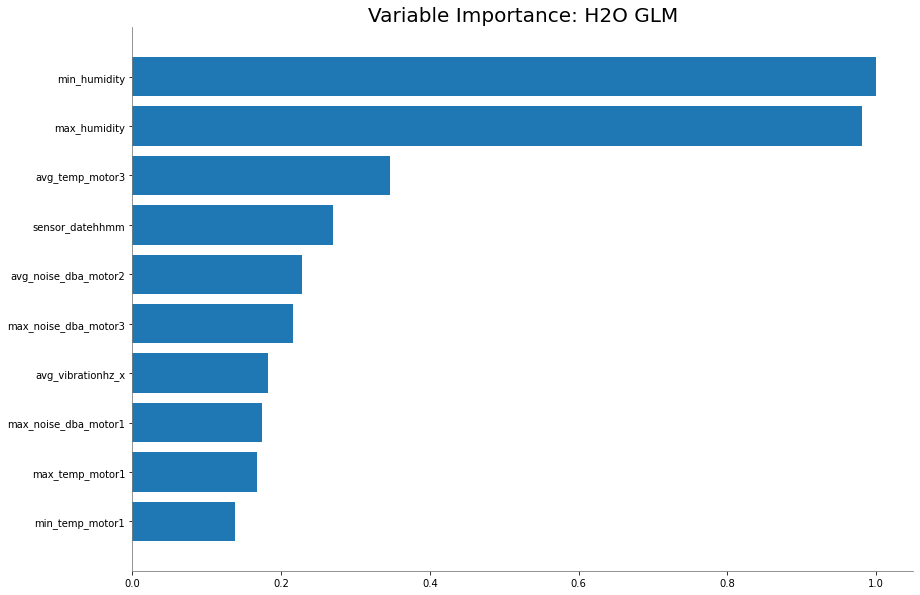

glm prediction progress: |████████████████████████████████████████████████| 100%


predict
50.1334
49.49
49.2532
49.6751
49.3953
49.5487
49.0409
49.3251
49.4166
49.4033




ModelMetricsRegressionGLM: glm
** Reported on test data. **

MSE: 3.602641539708791
RMSE: 1.8980625752879674
MAE: 1.5697676154896467
RMSLE: 0.037721453584119505
R^2: 0.05636676768169757
Mean Residual Deviance: 3.602641539708791
Null degrees of freedom: 47
Residual degrees of freedom: 21
Null deviance: 185.8906433281808
Residual deviance: 172.92679390602197
AIC: 253.73813138386976

--------MAE------- 1.5697676504577052
--------NMAE------- 0.16267022284535806


In [49]:
train_h2o=h2o.H2OFrame(train)
test_h2o=h2o.H2OFrame(test)

x = train_h2o.columns
y = target

experiment_name = 'provaconceito46'

client = MlflowClient()

try:
    experiment = mlflow.create_experiment(experiment_name)
except:
    experiment = client.get_experiment_by_name(experiment_name)
mlflow.set_experiment(experiment_name)


with mlflow.start_run():
    model = H2OAutoML(max_runtime_secs = 300, seed = 1, project_name = "provaconceito4", nfolds=10)
    model.train(x=x, y = y, training_frame = train_h2o)
   
    mlflow.log_param("runtime_sec", model.max_runtime_secs)
    mlflow.log_param("seed", model.seed)
    mlflow.log_param("nfolds", model.nfolds)
    mlflow.h2o.log_model(model.leader, "model")
    
    lb = model.leaderboard
    lb = get_leaderboard(model, extra_columns='ALL')
    print('')
    print(lb.head(rows=lb.nrows))
    model.leader.varimp_plot()
    pred = model.predict(test_h2o)
    print(pred.head())
    pred_df = h2o.as_list(pred)

    perf = model.leader.model_performance(test_h2o)
    print(perf)
    mae = MAE(test[y], pred_df)
    nmae = NMAE(mae, test[y])
    print('--------MAE-------', mae)
    print('--------NMAE-------', nmae)
    mlflow.log_metric("mae", mae)
    mlflow.log_metric("nmae", nmae)
    #exm = model.leader.explain_row(test_h2o, row_index=200)

#all_mlflow_runs = client.list_run_infos(experiment.experiment_id)
#if len(all_mlflow_runs) > 0:
#    run_info = all_mlflow_runs[-1]
#    model = mlflow.h2o.load_model("mlruns/{exp_id}/{run_id}/artifacts/model/".format(exp_id=experiment.experiment_id,run_id=run_info.run_uuid))
#    result = model.predict(test_h2o)
#else:
#    raise Exception('Run the training first')

In [50]:
pred_df = pred_df.reset_index(drop=True)

In [51]:
pred_df.index += 1400

In [52]:
pred_df

,predict
1400,50.133450
1401,49.489969
1402,49.253219
1403,49.675146
1404,49.395339
1405,49.548730
1406,49.040902
1407,49.325064
1408,49.416558
1409,49.403253


In [53]:
test

,sensor_datehhmm,sensor_ip,min_humidity,max_humidity,avg_humidity,min_temp_motor1,max_temp_motor1,avg_temp_motor1,min_temp_motor2,max_temp_motor2,...,min_noise_dba_motor1,max_noise_dba_motor1,avg_noise_dba_motor1,min_noise_dba_motor2,max_noise_dba_motor2,avg_noise_dba_motor2,min_noise_dba_motor3,max_noise_dba_motor3,avg_noise_dba_motor3,temp_count_hour
1400,2021-12-05 05:04:00,172.18.0.2,17,84,51.25,5,29,15.57,5,32,...,15,64,38.53,15,64,38.83,15,64,40.42,120
1401,2021-12-05 05:05:00,172.18.0.2,15,84,47.42,5,29,17.39,5,32,...,15,64,38.38,15,64,38.06,16,64,39.45,120
1402,2021-12-05 06:00:00,172.18.0.2,15,84,51.08,5,29,15.96,5,32,...,15,64,38.09,15,64,40.10,15,64,41.27,120
1403,2021-12-05 06:01:00,172.18.0.2,15,84,51.00,5,29,17.41,5,32,...,15,64,42.93,15,64,41.05,15,64,40.18,120
1404,2021-12-05 06:02:00,172.18.0.2,15,84,44.53,5,29,17.83,5,32,...,15,63,39.33,15,64,41.39,15,64,37.47,120
1405,2021-12-05 06:03:00,172.18.0.2,15,84,49.98,5,29,17.46,5,32,...,15,64,41.11,15,64,40.08,15,64,41.31,120
1406,2021-12-05 06:04:00,172.18.0.2,15,83,47.97,5,29,17.20,5,32,...,15,64,39.37,15,64,39.27,15,64,41.10,120
1407,2021-12-05 06:05:00,172.18.0.2,15,84,51.38,5,29,16.51,5,32,...,15,64,40.28,15,64,37.69,15,64,38.08,120
1408,2021-12-05 07:00:00,172.18.0.2,15,84,50.32,5,29,17.57,5,32,...,15,64,41.08,15,63,37.99,15,64,38.13,120
1409,2021-12-05 07:01:00,172.18.0.2,15,84,49.58,5,29,17.18,5,32,...,15,64,39.17,15,64,40.95,15,64,40.49,120


In [44]:
pip install plotly

Note: you may need to restart the kernel to use updated packages.


In [45]:
import plotly.express as px
import matplotlib.pyplot as plt

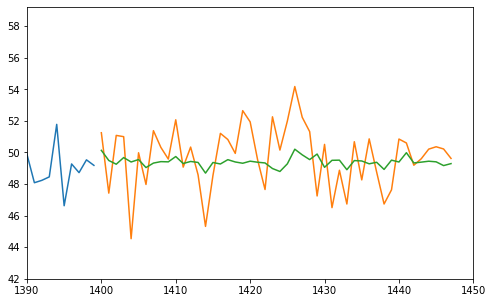

In [54]:
plt.figure(figsize=(8,5))
plt.plot(train['avg_humidity'],label="Training")
plt.plot(test['avg_humidity'],label="Test")
plt.plot(pred_df,label="Predicted")
plt.xlim([1390,1450])
plt.show()


In [70]:
dfconceitu = dfconceito.drop(['avg_temp_motor2', 'avg_temp_motor3', 'max_temp_motor2', 'max_temp_motor3', 'min_temp_motor2', 'min_temp_motor3', 'avg_noise_dba_motor3', 'avg_noise_dba_motor2', 'max_noise_dba_motor3', 'max_noise_dba_motor2', 'min_noise_dba_motor3', 'min_noise_dba_motor2', 'temp_count_hour', 'min_vibrationhz_z', 'min_vibrationhz_y', 'min_vibrationhz_x', 'max_vibrationhz_x', 'max_vibrationhz_y', 'max_vibrationhz_z' ], axis=1)

In [71]:
dfconceitu

,sensor_datehhmm,sensor_ip,min_humidity,max_humidity,avg_humidity,min_temp_motor1,max_temp_motor1,avg_temp_motor1,avg_vibrationhz_x,avg_vibrationhz_y,avg_vibrationhz_z,min_noise_dba_motor1,max_noise_dba_motor1,avg_noise_dba_motor1
0,2021-11-25 12:25:00,172.18.0.2,22,81,41.80,7,26,16.20,14.00,14.40,18.00,23,39,31.60
1,2021-11-25 12:26:00,172.18.0.2,18,84,56.58,7,28,15.75,14.67,15.08,15.17,19,57,39.67
2,2021-11-25 12:27:00,172.18.0.2,16,84,51.67,9,28,17.33,16.08,14.83,14.67,16,55,31.25
3,2021-11-25 12:28:00,172.18.0.2,15,82,42.92,5,28,20.25,15.92,18.08,17.25,18,64,45.17
4,2021-11-25 12:29:00,172.18.0.2,15,82,45.83,5,29,17.00,15.42,16.17,15.75,27,62,46.42
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6018,2021-11-29 16:43:00,172.18.0.2,15,83,52.67,5,29,19.42,15.25,16.50,16.08,18,63,43.50
6019,2021-11-29 16:44:00,172.18.0.2,18,63,40.67,7,29,20.17,15.33,14.50,14.67,15,64,39.67
6020,2021-11-29 16:45:00,172.18.0.2,17,76,40.17,6,27,20.25,16.00,13.92,16.00,17,52,33.75
6021,2021-11-29 16:46:00,172.18.0.2,15,78,52.75,7,28,19.83,14.42,14.92,15.83,23,57,41.83


In [80]:

target = 'avg_temp_motor1'
#train, test = train_test_split(dfconceito, test_size=0.2, random_state=25)
train = dfconceitu[0:5500]
test = dfconceitu[5500:6022]
col_obj=object(dfconceitu)

col_not_obj = not_object(dfconceitu)
col_not_obj.remove('avg_temp_motor1')

sensor_datehhmm
min_humidity
max_humidity
avg_humidity
min_temp_motor1
max_temp_motor1
avg_temp_motor1
avg_vibrationhz_x
avg_vibrationhz_y
avg_vibrationhz_z
min_noise_dba_motor1
max_noise_dba_motor1
avg_noise_dba_motor1
sensor_ip


Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
AutoML progress: |
22:11:51.368: New models will be added to existing leaderboard provaconceito4@@avg_temp_motor1 (leaderboard frame=null) with already 49 models.

█████████████████████████████████████████████████████
22:16:14.832: StackedEnsemble_BestOfFamily_AutoML_20211129_221151 [StackedEnsemble best (built using top model from each algorithm type)] failed: water.exceptions.H2OIllegalArgumentException: Failed to find the xval predictions frame. . .  Looks like keep_cross_validation_predictions wasn't set when building the models, or the frame was deleted.

███| 100%

22:16:15.836: StackedEnsemble_AllModels_AutoML_20211129_221151 [StackedEnsemble all (built using all AutoML models)] failed: water.exceptions.H2OIllegalArgumentException: Failed to find the xval predictions frame. . .  Looks like keep_cross_validation_predicti

model_id,mean_residual_deviance,rmse,mse,mae,rmsle,training_time_ms,predict_time_per_row_ms,algo
GLM_1_AutoML_20211129_221151,2.6769,1.63612,2.6769,1.29845,0.0926352,136,0.00054,GLM
GLM_1_AutoML_20211129_220624,2.6769,1.63612,2.6769,1.29845,0.0926352,135,0.000448,GLM
StackedEnsemble_BestOfFamily_AutoML_20211129_220624,2.68387,1.63825,2.68387,1.30017,0.0927802,115,0.001208,StackedEnsemble
StackedEnsemble_AllModels_AutoML_20211129_220624,2.68974,1.64004,2.68974,1.30214,0.0928701,457,0.021594,StackedEnsemble
GBM_grid__1_AutoML_20211129_221151_model_1,2.7108,1.64645,2.7108,1.31008,0.0932486,138,0.008517,GBM
GBM_grid__1_AutoML_20211129_220624_model_1,2.7108,1.64645,2.7108,1.31008,0.0932486,264,0.008357,GBM
GBM_grid__1_AutoML_20211129_221151_model_8,2.72815,1.65171,2.72815,1.31412,0.0935232,182,0.008496,GBM
GBM_grid__1_AutoML_20211129_220624_model_8,2.72815,1.65171,2.72815,1.31412,0.0935232,189,0.008341,GBM
GBM_grid__1_AutoML_20211129_220624_model_14,2.73877,1.65492,2.73877,1.31319,0.0936967,195,0.009887,GBM
GBM_grid__1_AutoML_20211129_221151_model_14,2.73877,1.65492,2.73877,1.31319,0.0936967,225,0.009828,GBM


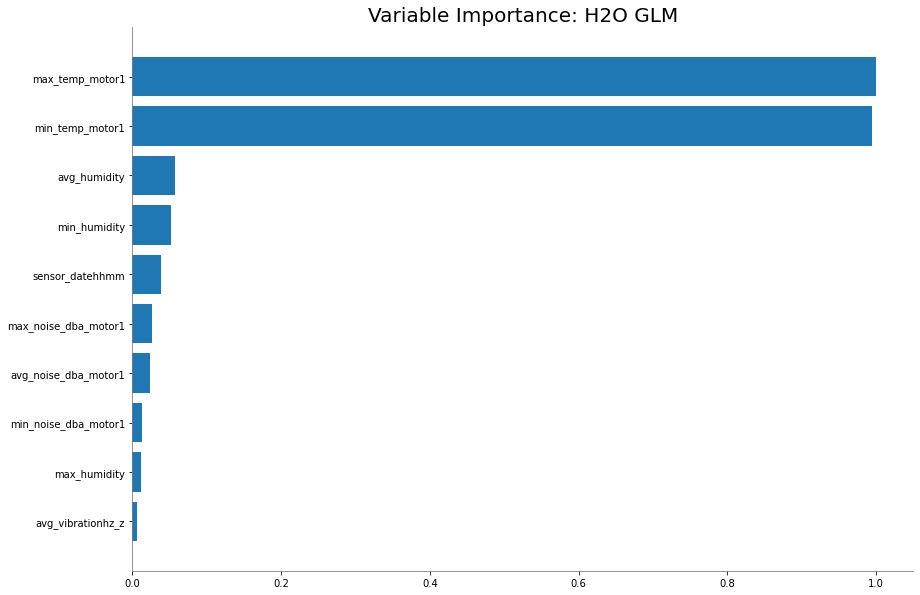

glm prediction progress: |████████████████████████████████████████████████| 100%


predict
53.3513
48.6783
43.5808
51.2184
48.8606
53.1491
52.1423
52.0458
48.9943
43.5035




ModelMetricsRegressionGLM: glm
** Reported on test data. **

MSE: 3.0091625675286124
RMSE: 1.7346937964749318
MAE: 1.3628290895640995
RMSLE: 0.0974913764353022
R^2: 0.3767242845879729
Mean Residual Deviance: 3.0091625675286124
Null degrees of freedom: 521
Residual degrees of freedom: 509
Null deviance: 2524.6555858205384
Residual deviance: 1570.7828602499358
AIC: 2084.4393004196218

--------MAE------- 1.3628290901487274
--------NMAE------- 0.1104399586830411


In [83]:
train_h2o=h2o.H2OFrame(train2)
test_h2o=h2o.H2OFrame(test2)

x = train_h2o.columns
y = target2

experiment_name = 'provaconceito4'

client = MlflowClient()

try:
    experiment = mlflow.create_experiment(experiment_name)
except:
    experiment = client.get_experiment_by_name(experiment_name)
mlflow.set_experiment(experiment_name)


with mlflow.start_run():
    model = H2OAutoML(max_runtime_secs = 300, seed = 1, project_name = "provaconceito4", nfolds=10)
    model.train(x=x, y = y, training_frame = train_h2o)
   
    mlflow.log_param("runtime_sec", model.max_runtime_secs)
    mlflow.log_param("seed", model.seed)
    mlflow.log_param("nfolds", model.nfolds)
    mlflow.h2o.log_model(model.leader, "model")
    
    lb = model.leaderboard
    lb = get_leaderboard(model, extra_columns='ALL')
    print('')
    print(lb.head(rows=lb.nrows))
    model.leader.varimp_plot()
    pred2 = model.predict(test_h2o)
    print(pred.head())
    pred_df2 = h2o.as_list(pred2)

    perf = model.leader.model_performance(test_h2o)
    print(perf)
    mae = MAE(test2[y], pred_df2)
    nmae = NMAE(mae, test[y])
    print('--------MAE-------', mae)
    print('--------NMAE-------', nmae)
    mlflow.log_metric("mae", mae)
    mlflow.log_metric("nmae", nmae)
    #exm = model.leader.explain_row(test_h2o, row_index=200)

#all_mlflow_runs = client.list_run_infos(experiment.experiment_id)
#if len(all_mlflow_runs) > 0:
#    run_info = all_mlflow_runs[-1]
#    model = mlflow.h2o.load_model("mlruns/{exp_id}/{run_id}/artifacts/model/".format(exp_id=experiment.experiment_id,run_id=run_info.run_uuid))
#    result = model.predict(test_h2o)
#else:
#    raise Exception('Run the training first')

In [86]:
pred_df2.index += 5500

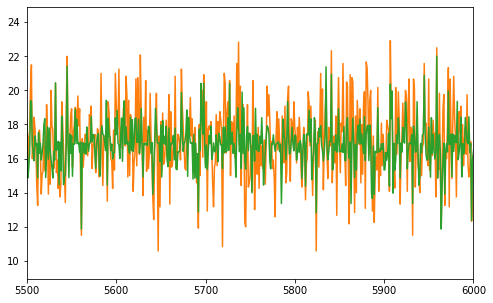

In [90]:
plt.figure(figsize=(8,5))
plt.plot(train2['avg_temp_motor1'],label="Training")
plt.plot(test2['avg_temp_motor1'],label="Test")
plt.plot(pred_df2,label="Predicted")
plt.xlim([5500,6000])
plt.show()

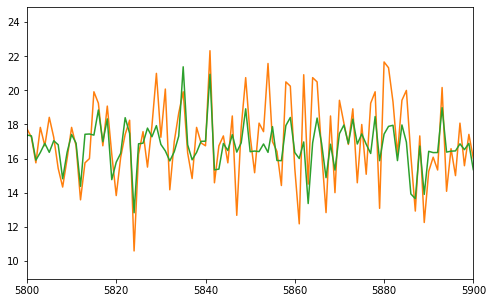

In [118]:
plt.figure(figsize=(8,5))
plt.plot(train2['avg_temp_motor1'],label="Training")
plt.plot(test2['avg_temp_motor1'],label="Test")
plt.plot(pred_df2,label="Predicted")
plt.xlim([5800,5900])
plt.show()

In [95]:
dfconceitu2 = dfconceito.drop(['avg_temp_motor2', 'avg_temp_motor3', 'max_temp_motor2', 'max_temp_motor3', 'min_temp_motor2', 'min_temp_motor3', 'avg_noise_dba_motor3', 'avg_noise_dba_motor2', 'max_noise_dba_motor3', 'max_noise_dba_motor2', 'min_noise_dba_motor3', 'min_noise_dba_motor2', 'temp_count_hour', 'min_vibrationhz_z', 'min_vibrationhz_y', 'min_vibrationhz_x', 'max_vibrationhz_x', 'max_vibrationhz_y', 'max_vibrationhz_z' ], axis=1)

In [98]:
target3 = 'max_temp_motor1'
#train, test = train_test_split(dfconceito, test_size=0.2, random_state=25)
train3 = dfconceitu2[0:5500]
test3 = dfconceitu2[5500:6022]
col_obj=object(dfconceitu2)

col_not_obj = not_object(dfconceitu2)
col_not_obj.remove('max_temp_motor1')

sensor_datehhmm
min_humidity
max_humidity
avg_humidity
min_temp_motor1
max_temp_motor1
avg_temp_motor1
avg_vibrationhz_x
avg_vibrationhz_y
avg_vibrationhz_z
min_noise_dba_motor1
max_noise_dba_motor1
avg_noise_dba_motor1
sensor_ip


Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
AutoML progress: |
22:26:06.688: New models will be added to existing leaderboard provaconceito5@@max_temp_motor1 (leaderboard frame=null) with already 14 models.
22:26:17.724: StackedEnsemble_BestOfFamily_AutoML_20211129_222606 [StackedEnsemble best (built using top model from each algorithm type)] failed: water.exceptions.H2OIllegalArgumentException: Failed to find the xval predictions frame. . .  Looks like keep_cross_validation_predictions wasn't set when building the models, or the frame was deleted.
22:26:18.727: StackedEnsemble_AllModels_AutoML_20211129_222606 [StackedEnsemble all (built using all AutoML models)] failed: water.exceptions.H2OIllegalArgumentException: Failed to find the xval predictions frame. . .  Looks like keep_cross_validation_predictions wasn't set when building the models, or the frame was deleted.


model_id,mean_residual_deviance,rmse,mse,mae,rmsle,training_time_ms,predict_time_per_row_ms,algo
GBM_grid__1_AutoML_20211129_222852_model_7,2.38193,1.54335,2.38193,1.18583,0.0573999,179,0.012155,GBM
GBM_grid__1_AutoML_20211129_222852_model_1,2.38831,1.54542,2.38831,1.18623,0.0574981,147,0.007748,GBM
GBM_grid__1_AutoML_20211129_222852_model_10,2.39386,1.54721,2.39386,1.1901,0.0575198,193,0.010589,GBM
GBM_grid__1_AutoML_20211129_222852_model_8,2.40661,1.55133,2.40661,1.18713,0.0577469,166,0.008135,GBM
GBM_grid__1_AutoML_20211129_222852_model_14,2.41082,1.55268,2.41082,1.19294,0.0578029,201,0.01001,GBM
GBM_5_AutoML_20211129_222852,2.42678,1.55781,2.42678,1.19541,0.0580179,283,0.014005,GBM
GBM_5_AutoML_20211129_222504,2.42678,1.55781,2.42678,1.19541,0.0580179,325,0.013708,GBM
GBM_grid__1_AutoML_20211129_222852_model_3,2.43059,1.55903,2.43059,1.19362,0.0580427,266,0.010977,GBM
GBM_2_AutoML_20211129_222504,2.44865,1.56481,2.44865,1.20103,0.0581556,242,0.013129,GBM
GBM_2_AutoML_20211129_222852,2.44865,1.56481,2.44865,1.20103,0.0581556,246,0.013277,GBM


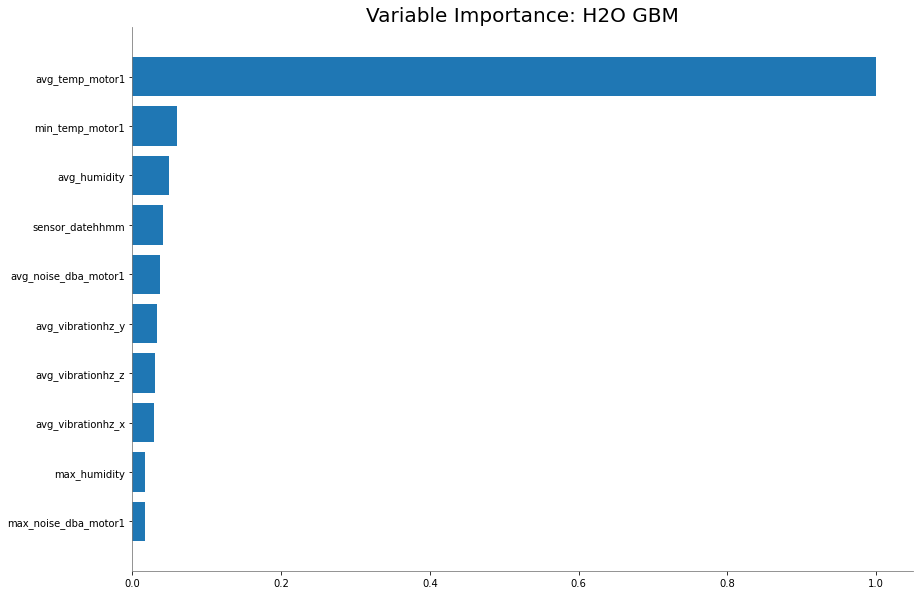

gbm prediction progress: |████████████████████████████████████████████████| 100%


predict
53.3513
48.6783
43.5808
51.2184
48.8606
53.1491
52.1423
52.0458
48.9943
43.5035




ModelMetricsRegression: gbm
** Reported on test data. **

MSE: 2.508814474259008
RMSE: 1.583923758979266
MAE: 1.1354033799602925
RMSLE: 0.05945795730183092
Mean Residual Deviance: 2.508814474259008

--------MAE------- 1.135403379960291
--------NMAE------- 0.1135403379960291


In [106]:
train_h2o=h2o.H2OFrame(train3)
test_h2o=h2o.H2OFrame(test3)

x = train_h2o.columns
y = target3

experiment_name = 'provaconceito5'

client = MlflowClient()

try:
    experiment = mlflow.create_experiment(experiment_name)
except:
    experiment = client.get_experiment_by_name(experiment_name)
mlflow.set_experiment(experiment_name)


with mlflow.start_run():
    model = H2OAutoML(max_runtime_secs = 300, seed = 1, project_name = "provaconceito5", nfolds=10)
    model.train(x=x, y = y, training_frame = train_h2o)
   
    mlflow.log_param("runtime_sec", model.max_runtime_secs)
    mlflow.log_param("seed", model.seed)
    mlflow.log_param("nfolds", model.nfolds)
    mlflow.h2o.log_model(model.leader, "model")
    
    lb = model.leaderboard
    lb = get_leaderboard(model, extra_columns='ALL')
    print('')
    print(lb.head(rows=lb.nrows))
    model.leader.varimp_plot()
    pred3 = model.predict(test_h2o)
    print(pred.head())
    pred_df3 = h2o.as_list(pred3)

    perf = model.leader.model_performance(test_h2o)
    print(perf)
    mae = MAE(test3[y], pred_df3)
    nmae = NMAE(mae, test3[y])
    print('--------MAE-------', mae)
    print('--------NMAE-------', nmae)
    mlflow.log_metric("mae", mae)
    mlflow.log_metric("nmae", nmae)
    #exm = model.leader.explain_row(test_h2o, row_index=200)

#all_mlflow_runs = client.list_run_infos(experiment.experiment_id)
#if len(all_mlflow_runs) > 0:
#    run_info = all_mlflow_runs[-1]
#    model = mlflow.h2o.load_model("mlruns/{exp_id}/{run_id}/artifacts/model/".format(exp_id=experiment.experiment_id,run_id=run_info.run_uuid))
#    result = model.predict(test_h2o)
#else:
#    raise Exception('Run the training first')

In [108]:
pred_df3.index += 5500

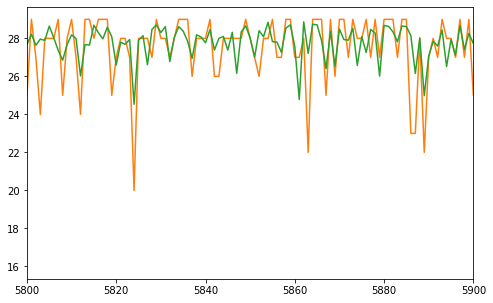

In [116]:
plt.figure(figsize=(8,5))
plt.plot(train3['max_temp_motor1'],label="Training")
plt.plot(test3['max_temp_motor1'],label="Test")
plt.plot(pred_df3,label="Predicted")
plt.xlim([5800,5900])
plt.show()

# 9. Auto-Arima

In [38]:
pip install pmdarima

     |████████████████████████████████| 1.4 MB 3.2 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [39]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [40]:
from pmdarima.arima import auto_arima
from pmdarima.arima import ADFTest

In [41]:
import matplotlib.pyplot as plt

In [54]:
dfconceito2

0       16.20
1       15.75
2       17.33
3       20.25
4       17.00
        ...  
6018    19.42
6019    20.17
6020    20.25
6021    19.83
6022    15.60
Name: avg_temp_motor1, Length: 6023, dtype: float64

In [80]:
dfconceito2 = dfconceito["avg_temp_motor1"]

In [72]:
import pandas as pd

In [77]:
dfconceito

,sensor_datehhmm,sensor_ip,min_humidity,max_humidity,avg_humidity,min_temp_motor1,max_temp_motor1,avg_temp_motor1,min_temp_motor2,max_temp_motor2,...,min_noise_dba_motor1,max_noise_dba_motor1,avg_noise_dba_motor1,min_noise_dba_motor2,max_noise_dba_motor2,avg_noise_dba_motor2,min_noise_dba_motor3,max_noise_dba_motor3,avg_noise_dba_motor3,temp_count_hour
0,2021-11-25 12:25:00,172.18.0.2,22,81,41.80,7,26,16.20,21,32,...,23,39,31.60,20,63,43.20,23,46,38.40,5
1,2021-11-25 12:26:00,172.18.0.2,18,84,56.58,7,28,15.75,6,32,...,19,57,39.67,19,63,41.42,16,48,32.58,12
2,2021-11-25 12:27:00,172.18.0.2,16,84,51.67,9,28,17.33,6,29,...,16,55,31.25,15,62,41.42,22,64,49.00,12
3,2021-11-25 12:28:00,172.18.0.2,15,82,42.92,5,28,20.25,8,31,...,18,64,45.17,21,52,39.42,21,64,45.17,12
4,2021-11-25 12:29:00,172.18.0.2,15,82,45.83,5,29,17.00,7,32,...,27,62,46.42,16,64,43.50,16,64,41.25,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6018,2021-11-29 16:43:00,172.18.0.2,15,83,52.67,5,29,19.42,10,30,...,18,63,43.50,20,57,33.17,19,62,36.08,12
6019,2021-11-29 16:44:00,172.18.0.2,18,63,40.67,7,29,20.17,5,32,...,15,64,39.67,15,60,28.75,25,59,43.92,12
6020,2021-11-29 16:45:00,172.18.0.2,17,76,40.17,6,27,20.25,6,32,...,17,52,33.75,24,62,43.33,16,64,37.58,12
6021,2021-11-29 16:46:00,172.18.0.2,15,78,52.75,7,28,19.83,5,30,...,23,57,41.83,20,54,40.67,15,63,36.83,12


In [83]:
dfconceito2 = dfconceito

In [108]:
dfconceito46 = dfconceito2.drop(columns=['sensor_datehhmm', 'sensor_ip', 'min_humidity', 'avg_humidity', 'max_humidity', 'min_temp_motor1', 'max_temp_motor1', 'min_temp_motor2', 'max_temp_motor2', 'avg_temp_motor2', 'min_temp_motor3', 'max_temp_motor3', 'avg_temp_motor3', 'min_noise_dba_motor1', 'avg_noise_dba_motor1', 'max_noise_dba_motor1', 'min_noise_dba_motor2', 'avg_noise_dba_motor2', 'max_noise_dba_motor2', 'min_noise_dba_motor3', 'avg_noise_dba_motor3', 'max_noise_dba_motor3', 'temp_count_hour', 'min_vibrationhz_x', 'avg_vibrationhz_x', 'max_vibrationhz_x', 'min_vibrationhz_y', 'avg_vibrationhz_y', 'max_vibrationhz_y', 'min_vibrationhz_z', 'avg_vibrationhz_z', 'max_vibrationhz_z'])


In [109]:
dfconceito46

,avg_temp_motor1
0,16.20
1,15.75
2,17.33
3,20.25
4,17.00
...,...
6018,19.42
6019,20.17
6020,20.25
6021,19.83


In [110]:
dfconceito46.to_csv('./df46.csv', index=False)

In [100]:
adf_test = ADFTest(alpha = 0.05)
adf_test.should_diff(dfconceito46)

(0.01, False)

In [127]:
dfconceito2.describe()

count    6023.000000
mean       16.964104
std         2.105236
min         9.670000
25%        15.500000
50%        17.000000
75%        18.330000
max        24.170000
Name: avg_temp_motor1, dtype: float64

In [129]:
# arima_model =  auto_arima(train, start_p=0, d=1, start_q=0,
#                          max_p=5, max_d=5, max_q=5, start_P=0,
#                          D=1, start_Q=0, max_P=5, max_D=5,
#                          max_Q=5, m=12, seasonal=True,
#                          error_action='warn',trace = True,
#                          supress_warnings=True,stepwise = True,
#                          random_state=20,n_fits = 50)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=5872.530, Time=0.08 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=5213.093, Time=0.34 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=2.56 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=5508.005, Time=0.10 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=5112.195, Time=1.06 sec
 ARIMA(1,1,0)(3,1,0)[12]             : AIC=5054.927, Time=2.03 sec
 ARIMA(1,1,0)(4,1,0)[12]             : AIC=5007.364, Time=4.03 sec
 ARIMA(1,1,0)(5,1,0)[12]             : AIC=4971.441, Time=14.96 sec
 ARIMA(1,1,0)(5,1,1)[12]             : AIC=inf, Time=71.16 sec
 ARIMA(1,1,0)(4,1,1)[12]             : AIC=inf, Time=39.35 sec
 ARIMA(0,1,0)(5,1,0)[12]             : AIC=5279.068, Time=7.20 sec
 ARIMA(2,1,0)(5,1,0)[12]             : AIC=4861.126, Time=11.18 sec
 ARIMA(2,1,0)(4,1,0)[12]             : AIC=4895.533, Time=6.75 sec


KeyboardInterrupt: 

In [63]:
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                 1035
Model:             SARIMAX(5, 1, 0)x(5, 1, 0, 12)   Log Likelihood               -2369.121
Date:                            Mon, 29 Nov 2021   AIC                           4760.242
Time:                                    12:56:38   BIC                           4814.467
Sample:                                         0   HQIC                          4780.829
                                           - 1035                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8735      0.032    -27.436      0.000      -0.936      -0.811
ar.L2         -0.6816      0.043    -15.796      0.000      -0.766      -0.597
ar.L3         -0.5564      0.045    -12.273      0.000      -0.645      -0.468
ar.L4         -0.3942      0.044     -9.023      0.000      -0.480      -0.309
ar.L5         -0.1584      0.032     -4.957      0.000      -0.221      -0.096
ar.S.L12      -0.8283      0.033    -25.132      0.000      -0.893      -0.764
ar.S.L24      -0.6361      0.043    -14.799      0.000      -0.720      -0.552
ar.S.L36      -0.4646      0.045    -10.358      0.000      -0.553      -0.377
ar.S.L48      -0.3245      0.041     -7.839      0.000      -0.406      -0.243
ar.S.L60      -0.1737      0.033     -5.238      0.000      -0.239      -0.109
sigma2         5.9639      0.261     22.875      0.000       5.453       6.475
===================================================================================
Ljung-Box (L1) (Q):                   0.52   Jarque-Bera (JB):                 2.10
Prob(Q):                              0.47   Prob(JB):                         0.35
Heteroskedasticity (H):               1.04   Skew:                             0.10
Prob(H) (two-sided):                  0.70   Kurtosis:                         3.10
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [113]:
prediction = pd.DataFrame(arima_model.predict(n_periods = len(test2)), index=test2.index)
prediction.columns = ['avg_temp_motor1']
prediction

,avg_temp_motor1
1035,14.424566
1036,13.574365
1037,12.498432
1038,13.348996
1039,12.549083
1040,12.951781
1041,14.613540
1042,15.044760
1043,14.566619


ConversionError: Failed to convert value(s) to axis units: array(['172.18.0.2', '172.18.0.2', '172.18.0.2', ..., '172.18.0.2',
       '172.18.0.2', '172.18.0.2'], dtype=object)

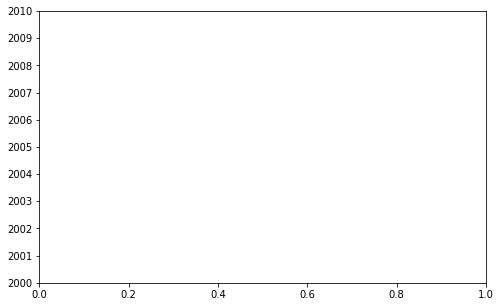

In [119]:
plt.figure(figsize=(8,5))
plt.plot(train2,label="Training")
plt.plot(test2,label="Test")
plt.plot(prediction,label="Predicted")
plt.xlim([1000,1050])
plt.show()



In [56]:
pip install cane

Note: you may need to restart the kernel to use updated packages.


In [96]:
def hold(y, ratio=2 / 3, mode="rolling", it=1, window=10, increment=1):
    #ratio = test size
    #window = traingin size
    ALLITR = None
    VAL = None
    NSIZE = len(y)
    if mode == "incremental" or mode == "rolling":
        aux = window + increment * (it - 1)
        aux = min(aux, NSIZE)
        if mode == "rolling":
            iaux = max((aux - window + 1), 1)
        else:
            iaux = 1
        ALLTR = range(iaux, aux)
        end = aux + ratio
        end = min(end, NSIZE)
        iend = aux + 1
        if iend < end:
            TS = range(iend, end)
        else:
            TS = None
    return {"tr": ALLTR, "itr": ALLITR, "val": VAL, "ts": TS}

In [97]:
def calcIterationsRW(datasetSize, trainingSize, testSize, stepSize): 
    
    return int((datasetSize - (trainingSize + testSize))/ stepSize)


trainingSize = 1023 
testSize = 15
ratio = testSize
stepSize = 200
#totalLenght = df.shape[0]
mode = "rolling"

#For all records
iterations = calcIterationsRW(dfconceito46.shape[0], trainingSize, testSize, stepSize)

#For only positive records
#iterations = calcIterationsRW(len(df['serial'].unique()), trainingSize, testSize, stepSize)

iterations

24

In [102]:
from pmdarima.arima import auto_arima
from tqdm import trange
from sklearn.metrics import mean_absolute_error

def runarima(data, iterations):
    max_value = data['min_temp_motor1'].max()
    min_value = data['min_temp_motor1'].min()
    denominator = max_value - min_value
    
    dfFinal = pd.DataFrame(columns = ['MAE', 'NMAE'])
    
    MAEVals = []
    NMAEVals = []
   
    for i in trange(iterations):

            holds = hold(data[['min_temp_motor1']], ratio, mode, i+1, trainingSize, stepSize)
            print('holds')
            print("Iteration ", i+1 , "of ", iterations, " TR: ", holds['tr'] , "TS: ", holds['ts'])
            tr = data.iloc[holds['tr']].reset_index(drop=True)
            ts = data.iloc[holds['ts']].reset_index(drop=True)
            
            model =  auto_arima(tr[["avg_temp_motor1"]], start_p=0, d=1, start_q=0, 
                          max_p=5, max_d=5, max_q=5, start_P=0, 
                          D=1, start_Q=0, max_P=5, max_D=5,
                          max_Q=5, m=12, seasonal=True, 
                          error_action='warn',trace = True,
                          supress_warnings=True,stepwise = True,
                          random_state=20,n_fits = 20)
            
            p = model.predict(n_periods=5)
            MAE = mean_absolute_error(ts.values.tolist(), p)
            NMAE = (MAE/denominator)*100 #o denominador é calculado com o maximo e minimo global
            
            print("Iteration ", i , "MAE ", MAE, "NMAE of ", NMAE)
            
            MAEVals.append(MAE)
            NMAEVals.append(NMAE)
        
            new = {'MAE': MAE, 'NMAE': NMAE}
            dfFinal = dfFinal.append(new, ignore_index=True)
            dfFinal = pd.DataFrame(dfFinal)
            
    return dfFinal

In [105]:
dfResults = runarima(dfconceito46,iterations)

  0%|          | 0/24 [00:00<?, ?it/s]


TypeError: min() takes 1 positional argument but 2 were given

# 10. Prophet


![prophet2](./images/prophet2.png)

#### Prophet is a procedure for forecasting time series data based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects. It works best with time series that have strong seasonal effects and several seasons of historical data. Prophet is robust to missing data and shifts in the trend, and typically handles outliers well.

In [131]:
pip install fbprophet

  Using cached fbprophet-0.7.1.tar.gz (64 kB)
  Created wheel for fbprophet: filename=fbprophet-0.7.1-py3-none-any.whl size=9433377 sha256=445bc552be2fec0c59a362e029650f3e8520a474781547c8f2b5eead41aa1845
  Stored in directory: /home/jovyan/.cache/pip/wheels/cd/a1/12/db63ff624de492fe6cccf676091a0860fdde2ffde4bc3280e2
Successfully built fbprophet
Note: you may need to restart the kernel to use updated packages.


In [175]:
from fbprophet import Prophet
from sklearn.model_selection import train_test_split

dfconceito2 = dfconceito[["sensor_datehhmm", "avg_humidity"]]
df = dfconceito2

train = df[0:5500]
test = df[5500:6022]

#train, test = train_test_split(df, test_size=0.2)

df['sensor_date_hhmm'] = pd.to_datetime(df['sensor_datehhmm'])
df = df.set_index('sensor_datehhmm')

_df = df.resample('D').mean()
_df = _df.reset_index().dropna()
_df.columns = ['ds', 'y']

df = _df.rename({'sensor_datehhmm': 'ds', 'avg_humidity' : 'y'}, axis=1)  # new method   
df_train = train[['sensor_datehhmm', 'avg_humidity']]
df_train = df_train.rename({'sensor_datehhmm': 'ds', 'avg_humidity' : 'y'}, axis=1)  # new method

df_test = test[['sensor_datehhmm', 'avg_humidity']]
df_test = df_test.rename({'sensor_datehhmm': 'ds', 'avg_humidity' : 'y'}, axis=1)  # new method

m = Prophet()
m.fit(df_train)

predictions = m.predict(df_test)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Initial log joint probability = -33.5059
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99         10713    0.00233755       159.291       0.324      0.8203      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     125       10713.5   9.13198e-05       101.054   5.025e-07       0.001      197  LS failed, Hessian reset 
     166       10713.8   0.000133624       154.896   1.137e-06       0.001      275  LS failed, Hessian reset 
     199       10713.9   0.000135775       69.4742           1           1      316   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     256         10714   5.95865e-06       73.5598   7.608e-08       0.001      423  LS failed, Hessian reset 
     260         10714   8.10674e-07       54.6628           1           1      429   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is

In [176]:
df

,ds,y
0,2021-11-25,49.816863
1,2021-11-26,49.525194
2,2021-11-27,49.379701
3,2021-11-28,49.673889
4,2021-11-29,49.504593


In [178]:
import numpy as np

EPSILON = 1e-10


def _error(actual: np.ndarray, predicted: np.ndarray):
    """Simple error"""
    return actual - predicted


def _percentage_error(actual: np.ndarray, predicted: np.ndarray):
    """
    Percentage error
    Note: result is NOT multiplied by 100
    """
    return _error(actual, predicted) / (actual + EPSILON)


def _naive_forecasting(actual: np.ndarray, seasonality: int = 1):
    """Naive forecasting method which just repeats previous samples"""
    return actual[:-seasonality]


def _relative_error(
    actual: np.ndarray, predicted: np.ndarray, benchmark: np.ndarray = None
):
    """Relative Error"""
    if benchmark is None or isinstance(benchmark, int):
        # If no benchmark prediction provided - use naive forecasting
        if not isinstance(benchmark, int):
            seasonality = 1
        else:
            seasonality = benchmark
        return _error(actual[seasonality:], predicted[seasonality:]) / (
            _error(actual[seasonality:], _naive_forecasting(actual, seasonality))
            + EPSILON
        )

    return _error(actual, predicted) / (_error(actual, benchmark) + EPSILON)


def _bounded_relative_error(
    actual: np.ndarray, predicted: np.ndarray, benchmark: np.ndarray = None
):
    """Bounded Relative Error"""
    if benchmark is None or isinstance(benchmark, int):
        # If no benchmark prediction provided - use naive forecasting
        if not isinstance(benchmark, int):
            seasonality = 1
        else:
            seasonality = benchmark

        abs_err = np.abs(_error(actual[seasonality:], predicted[seasonality:]))
        abs_err_bench = np.abs(
            _error(actual[seasonality:], _naive_forecasting(actual, seasonality))
        )
    else:
        abs_err = np.abs(_error(actual, predicted))
        abs_err_bench = np.abs(_error(actual, benchmark))

    return abs_err / (abs_err + abs_err_bench + EPSILON)


def _geometric_mean(a, axis=0, dtype=None):
    """Geometric mean"""
    if not isinstance(a, np.ndarray):  # if not an ndarray object attempt to convert it
        log_a = np.log(np.array(a, dtype=dtype))
    elif dtype:  # Must change the default dtype allowing array type
        if isinstance(a, np.ma.MaskedArray):
            log_a = np.log(np.ma.asarray(a, dtype=dtype))
        else:
            log_a = np.log(np.asarray(a, dtype=dtype))
    else:
        log_a = np.log(a)
    return np.exp(log_a.mean(axis=axis))


def mse(actual: np.ndarray, predicted: np.ndarray):
    """Mean Squared Error"""
    return np.mean(np.square(_error(actual, predicted)))


def rmse(actual: np.ndarray, predicted: np.ndarray):
    """Root Mean Squared Error"""
    return np.sqrt(mse(actual, predicted))


def nrmse(actual: np.ndarray, predicted: np.ndarray):
    """Normalized Root Mean Squared Error"""
    return rmse(actual, predicted) / (actual.max() - actual.min())


def r2(actual: np.ndarray, predicted: np.ndarray):
    from sklearn.metrics import r2_score

    return r2_score(actual, predicted)


def me(actual: np.ndarray, predicted: np.ndarray):
    """Mean Error"""
    return np.mean(_error(actual, predicted))


def mae(actual: np.ndarray, predicted: np.ndarray):
    """Mean Absolute Error"""
    return np.mean(np.abs(_error(actual, predicted)))


def nmae(actual: np.ndarray, predicted: np.ndarray):
    """Normalized Mean Absolute Error"""
    return 100 * (mae(actual, predicted) / abs(actual.max() - actual.min()))


mad = mae  # Mean Absolute Deviation (it is the same as MAE)


def gmae(actual: np.ndarray, predicted: np.ndarray):
    """Geometric Mean Absolute Error"""
    return _geometric_mean(np.abs(_error(actual, predicted)))


def mdae(actual: np.ndarray, predicted: np.ndarray):
    """Median Absolute Error"""
    return np.median(np.abs(_error(actual, predicted)))


def mpe(actual: np.ndarray, predicted: np.ndarray):
    """Mean Percentage Error"""
    return np.mean(_percentage_error(actual, predicted))


def mape(actual: np.ndarray, predicted: np.ndarray):
    """
    Mean Absolute Percentage Error
    Properties:
        + Easy to interpret
        + Scale independent
        - Biased, not symmetric
        - Undefined when actual[t] == 0
    Note: result is NOT multiplied by 100
    """
    return np.mean(np.abs(_percentage_error(actual, predicted)))


def mdape(actual: np.ndarray, predicted: np.ndarray):
    """
    Median Absolute Percentage Error
    Note: result is NOT multiplied by 100
    """
    return np.median(np.abs(_percentage_error(actual, predicted)))


def smape(actual: np.ndarray, predicted: np.ndarray):
    """
    Symmetric Mean Absolute Percentage Error
    Note: result is NOT multiplied by 100
    """
    return np.mean(
        2.0
        * np.abs(actual - predicted)
        / ((np.abs(actual) + np.abs(predicted)) + EPSILON)
    )


def smdape(actual: np.ndarray, predicted: np.ndarray):
    """
    Symmetric Median Absolute Percentage Error
    Note: result is NOT multiplied by 100
    """
    return np.median(
        2.0
        * np.abs(actual - predicted)
        / ((np.abs(actual) + np.abs(predicted)) + EPSILON)
    )


def maape(actual: np.ndarray, predicted: np.ndarray):
    """
    Mean Arctangent Absolute Percentage Error
    Note: result is NOT multiplied by 100
    """
    return np.mean(np.arctan(np.abs((actual - predicted) / (actual + EPSILON))))


def mase(actual: np.ndarray, predicted: np.ndarray, seasonality: int = 1):
    """
    Mean Absolute Scaled Error
    Baseline (benchmark) is computed with naive forecasting (shifted by @seasonality)
    """
    return mae(actual, predicted) / mae(
        actual[seasonality:], _naive_forecasting(actual, seasonality)
    )


def std_ae(actual: np.ndarray, predicted: np.ndarray):
    """Normalized Absolute Error"""
    __mae = mae(actual, predicted)
    return np.sqrt(
        np.sum(np.square(_error(actual, predicted) - __mae)) / (len(actual) - 1)
    )


def std_ape(actual: np.ndarray, predicted: np.ndarray):
    """Normalized Absolute Percentage Error"""
    __mape = mape(actual, predicted)
    return np.sqrt(
        np.sum(np.square(_percentage_error(actual, predicted) - __mape))
        / (len(actual) - 1)
    )


def rmspe(actual: np.ndarray, predicted: np.ndarray):
    """
    Root Mean Squared Percentage Error
    Note: result is NOT multiplied by 100
    """
    return np.sqrt(np.mean(np.square(_percentage_error(actual, predicted))))


def rmdspe(actual: np.ndarray, predicted: np.ndarray):
    """
    Root Median Squared Percentage Error
    Note: result is NOT multiplied by 100
    """
    return np.sqrt(np.median(np.square(_percentage_error(actual, predicted))))


def rmsse(actual: np.ndarray, predicted: np.ndarray, seasonality: int = 1):
    """Root Mean Squared Scaled Error"""
    q = np.abs(_error(actual, predicted)) / mae(
        actual[seasonality:], _naive_forecasting(actual, seasonality)
    )
    return np.sqrt(np.mean(np.square(q)))


def inrse(actual: np.ndarray, predicted: np.ndarray):
    """Integral Normalized Root Squared Error"""
    return np.sqrt(
        np.sum(np.square(_error(actual, predicted)))
        / np.sum(np.square(actual - np.mean(actual)))
    )


def rrse(actual: np.ndarray, predicted: np.ndarray):
    """Root Relative Squared Error"""
    return np.sqrt(
        np.sum(np.square(actual - predicted))
        / np.sum(np.square(actual - np.mean(actual)))
    )


def mre(actual: np.ndarray, predicted: np.ndarray, benchmark: np.ndarray = None):
    """Mean Relative Error"""
    return np.mean(_relative_error(actual, predicted, benchmark))


def rae(actual: np.ndarray, predicted: np.ndarray):
    """Relative Absolute Error (aka Approximation Error)"""
    return np.sum(np.abs(actual - predicted)) / (
        np.sum(np.abs(actual - np.mean(actual))) + EPSILON
    )


def mrae(actual: np.ndarray, predicted: np.ndarray, benchmark: np.ndarray = None):
    """Mean Relative Absolute Error"""
    return np.mean(np.abs(_relative_error(actual, predicted, benchmark)))


def mdrae(actual: np.ndarray, predicted: np.ndarray, benchmark: np.ndarray = None):
    """Median Relative Absolute Error"""
    return np.median(np.abs(_relative_error(actual, predicted, benchmark)))


def gmrae(actual: np.ndarray, predicted: np.ndarray, benchmark: np.ndarray = None):
    """Geometric Mean Relative Absolute Error"""
    return _geometric_mean(np.abs(_relative_error(actual, predicted, benchmark)))


def mbrae(actual: np.ndarray, predicted: np.ndarray, benchmark: np.ndarray = None):
    """Mean Bounded Relative Absolute Error"""
    return np.mean(_bounded_relative_error(actual, predicted, benchmark))


def umbrae(actual: np.ndarray, predicted: np.ndarray, benchmark: np.ndarray = None):
    """Unscaled Mean Bounded Relative Absolute Error"""
    __mbrae = mbrae(actual, predicted, benchmark)
    return __mbrae / (1 - __mbrae)


def mda(actual: np.ndarray, predicted: np.ndarray):
    """Mean Directional Accuracy"""
    return np.mean(
        (
            np.sign(actual[1:] - actual[:-1]) == np.sign(predicted[1:] - predicted[:-1])
        ).astype(int)
    )


METRICS = {
    "r2": r2,
    "mse": mse,
    "rmse": rmse,
    "nrmse": nrmse,
    "me": me,
    "mae": mae,
    "nmae": nmae,
    "mad": mad,
    "gmae": gmae,
    "mdae": mdae,
    "mpe": mpe,
    "mape": mape,
    "mdape": mdape,
    "smape": smape,
    "smdape": smdape,
    "maape": maape,
    "mase": mase,
    "std_ae": std_ae,
    "std_ape": std_ape,
    "rmspe": rmspe,
    "rmdspe": rmdspe,
    "rmsse": rmsse,
    "inrse": inrse,
    "rrse": rrse,
    "mre": mre,
    "rae": rae,
    "mrae": mrae,
    "mdrae": mdrae,
    "gmrae": gmrae,
    "mbrae": mbrae,
    "umbrae": umbrae,
    "mda": mda,
}


def evaluate(
    actual: np.ndarray,
    predicted: np.ndarray,
    metrics=("r2", "mae", "nmae", "mse", "rmse", "rmspe", "rae", "mape"),
):
    results = {}
    for name in metrics:
        try:
            results[name] = METRICS[name](actual, predicted)
        except Exception as err:
            results[name] = np.nan
            print("Unable to compute metric {0}: {1}".format(name, err))
    return results


def evaluate_all(actual: np.ndarray, predicted: np.ndarray):
    return evaluate(actual, predicted, metrics=set(METRICS.keys()))

In [179]:
metrics = evaluate(df_test['y'].to_numpy(), predictions['yhat'].to_numpy())
eval_df = pd.DataFrame([metrics], columns=metrics.keys()).round(3)
eval_df["target"] = 'avg_humidity'
eval_df

,r2,mae,nmae,mse,rmse,rmspe,rae,mape,target
0,-0.006,4.858,13.589,36.985,6.082,0.13,0.999,0.101,avg_humidity


In [180]:
predictions

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2021-11-29 08:05:00,49.723292,41.805725,56.553277,49.723292,49.723292,-0.382366,-0.382366,-0.382366,-0.382366,-0.382366,-0.382366,0.0,0.0,0.0,49.340925
1,2021-11-29 08:06:00,49.723442,41.973511,56.564086,49.723442,49.723442,-0.381297,-0.381297,-0.381297,-0.381297,-0.381297,-0.381297,0.0,0.0,0.0,49.342145
2,2021-11-29 08:07:00,49.723593,41.590193,56.864161,49.723593,49.723593,-0.380193,-0.380193,-0.380193,-0.380193,-0.380193,-0.380193,0.0,0.0,0.0,49.343400
3,2021-11-29 08:08:00,49.723743,41.795871,56.933675,49.723743,49.723743,-0.379052,-0.379052,-0.379052,-0.379052,-0.379052,-0.379052,0.0,0.0,0.0,49.344691
4,2021-11-29 08:09:00,49.723894,42.279756,57.597870,49.723894,49.723894,-0.377877,-0.377877,-0.377877,-0.377877,-0.377877,-0.377877,0.0,0.0,0.0,49.346017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
517,2021-11-29 16:42:00,49.801141,42.830900,57.604872,49.792853,49.809904,0.304386,0.304386,0.304386,0.304386,0.304386,0.304386,0.0,0.0,0.0,50.105527
518,2021-11-29 16:43:00,49.801292,42.128491,57.000004,49.792965,49.810089,0.303392,0.303392,0.303392,0.303392,0.303392,0.303392,0.0,0.0,0.0,50.104683
519,2021-11-29 16:44:00,49.801442,42.494547,57.287830,49.793080,49.810275,0.302360,0.302360,0.302360,0.302360,0.302360,0.302360,0.0,0.0,0.0,50.103802
520,2021-11-29 16:45:00,49.801593,42.764912,57.462664,49.793195,49.810460,0.301290,0.301290,0.301290,0.301290,0.301290,0.301290,0.0,0.0,0.0,50.102883


In [181]:
df_test

,ds,y
5500,2021-11-29 08:05:00,64.33
5501,2021-11-29 08:06:00,43.33
5502,2021-11-29 08:07:00,44.42
5503,2021-11-29 08:08:00,45.58
5504,2021-11-29 08:09:00,49.08
...,...,...
6017,2021-11-29 16:42:00,49.25
6018,2021-11-29 16:43:00,52.67
6019,2021-11-29 16:44:00,40.67
6020,2021-11-29 16:45:00,40.17
